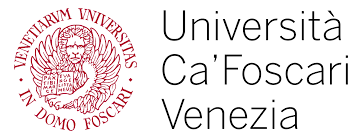

<center><h1> PROGETTO DATA AND WEB MINING 2020/2021</h1></center>

_Giosuè Zannini matr. 873810_

# Predizione
## Indice

* [1 Caricamento del dataset](#1)
* [2 Algoritmi di predizione](#2)
    * [2.1 K-Nearest-Neighbor](#2.1)
        * [2.1.1 Funzione MinKowski con euclidean_distance](#2.1.1)
        * [2.1.2 Funzione MinKowski con manhattan_distance](#2.1.2)
    * [2.2 Regressione lineare](#2.2)
    * [2.3 Albero di decisione](#2.3)
        * [2.3.1 Funzione per la misura della qualità dello split : mse](#2.3.1)
        * [2.3.2 Funzione per la misura della qualità dello split : mae](#2.3.2)
        * [2.3.3 Funzione per la misura della qualità dello split : friedman_mse](#2.3.3)
    * [2.4 Bagging algorithm](#2.4)
    * [2.5 AdaBoost](#2.5)
        * [2.5.1 Funzione per l'aggiornamento dei pesi : linear](#2.5.1)
        * [2.5.2 Funzione per l'aggiornamento dei pesi : square](#2.5.2)
        * [2.5.3 Funzione per l'aggiornamento dei pesi : exponential](#2.5.3)
    * [2.6 Random forest](#2.6)
        * [2.6.1 Funzione per la misura della qualità dello split : mse](#2.6.1)
        * [2.6.2 Funzione per la misura della qualità dello split : mae](#2.6.2)
* [3 Confronto algoritmi di predizione](#3)
    * [3.1 K-Nearest-Neighbor(Manhattan distance) VS Albero di decisione (mae)](#3.1)
    * [3.2 Random forest(mse) VS AdaBoost (linear)](#3.2)
* [4 Miglior predizione](#4)   
    * [1 Features più rilevanti](#4.1)   
    * [2 Modello parsimonioso](#4.2)   
* [5 Conclusioni](#5)   

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None) #serve per stampare l'intero df
import numpy as np

import sys

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from scipy import stats
from statsmodels.formula.api import ols as lm

import seaborn as sb
import matplotlib.pyplot as plt
plt.grid(color='w', linestyle='solid')

%matplotlib inline

<a id="1"/></a>
## 1 Caricamento del dataSet

In [2]:
df = pd.read_csv("C:/Users/zanna/JupyterAnaconda/Project/Dataset movie/train_custom.csv")

<a id="2"/></a>
## 2 Algoritmi di predizione

<a id="2.1"/></a>
### 1 K-Nearest-Neighbor

Il k-nearest neighbors (k-NN) è un algoritmo utilizzato nel riconoscimento di pattern per la classificazione di oggetti basandosi sulle caratteristiche degli oggetti vicini a quello considerato. In entrambi i casi, l'input è costituito dai k esempi di addestramento più vicini nello spazio delle funzionalità. L'output per la regressione è la media dei valori di k vicini più vicini.

In [3]:
# mi fa il tuning dei parametri per l'algoritmo
def tuning_knn(max_neighbors, function_of_MinKowski = 2, custom_fun = None, font_size = 1):
    sb.set(font_scale = font_size)
    df_knn = pd.DataFrame(columns = ["Neighbors", "R^2", "SSR", "Bias^2", "Variance"]) #creo il df per inserire i valori per ogni ciclo di for
    for i in range(1, max_neighbors + 1):
        if custom_fun == None: 
            knn = KNeighborsRegressor(n_neighbors = i, p = function_of_MinKowski)
        else:
            knn = KNeighborsRegressor(n_neighbors = i, metric = custom_fun)
        knn.fit(x_train, y_train) #train
        y_predict = knn.predict(x_validate) #predict
        # inserisco nel df i dati della predizione
        df_knn = df_knn.append({"Neighbors" : i, "R^2" : knn.score(x_validate, y_validate), "SSR" : sum((y_predict - y_validate)**2), 
                                "Bias^2" : np.mean((np.mean(y_predict) - y_validate)**2), "Variance" : np.var(y_predict)}, ignore_index = True)
    #grafici riguardanti il tuning dei parametri    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
    for i, ax in enumerate(axs[0,]): #prima riga
        sb.lineplot(ax = ax, data = df_knn, x = "Neighbors", y = df_knn.columns[i + 1])
    for i, ax in enumerate(axs[1,]): #seconda riga
        sb.lineplot(ax = ax, data = df_knn, x = "Neighbors", y = df_knn.columns[i + 3])
    return df_knn

 #dato il df trovo la miglior predizione e faccio un summary di grafici
def summary_knn_best(df_knn, function_of_MinKowski = 2, custom_fun = None):
    sb.set(font_scale = 1.5) #modifico la scala
    print(df_knn.iloc[df_knn["R^2"].idxmax()]) #print dei parametri per il miglior tuning dell'algoritmo
    if custom_fun == None: # istanzio l'algoritmo senza custom_fun
        knn = KNeighborsRegressor(n_neighbors = int(df_knn.iloc[df_knn["R^2"].idxmax()]["Neighbors"]),
                                  p = function_of_MinKowski)
    else: # istanzio l'algoritmo con custom_fun
        knn = KNeighborsRegressor(n_neighbors = int(df_knn.iloc[df_knn["R^2"].idxmax()]["Neighbors"]),
                                  metric = custom_fun)
    knn.fit(x_train, y_train) # train
    # creo un summary di grafici per la miglior predizione
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici, 4 righe e 4 colonne
    ax0 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[0, 2:])] #creo asse per la prima riga
    ax1 = [fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[1, 2:])] #creo asse per la seconda riga
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    for i, ax in enumerate(ax0): #prima riga di grafici
        sb.lineplot(ax = ax, data = df_knn, x = "Neighbors", y = df_knn.columns[i + 1]) #grafico
        ax.axvline(x = int(df_knn.iloc[df_knn["R^2"].idxmax()]["Neighbors"]), color = "red", #retta verticale per il n di vicini scelti
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    for i, ax in enumerate(ax1): #seconda riga di grafici
        sb.lineplot(ax = ax, data = df_knn, x = "Neighbors", y = df_knn.columns[i + 3]) #grafico
        ax.axvline(x = int(df_knn.iloc[df_knn["R^2"].idxmax()]["Neighbors"]), color = "red", #retta verticale per il n di vicini scelti
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    l_residual = abs(knn.predict(x_test) - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale
    
    

In [4]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

<a id="2.1.1"/></a>
#### 1 Funzione MinKowski con euclidean_distance
$\sqrt{(\sum(x- y)^2)}$

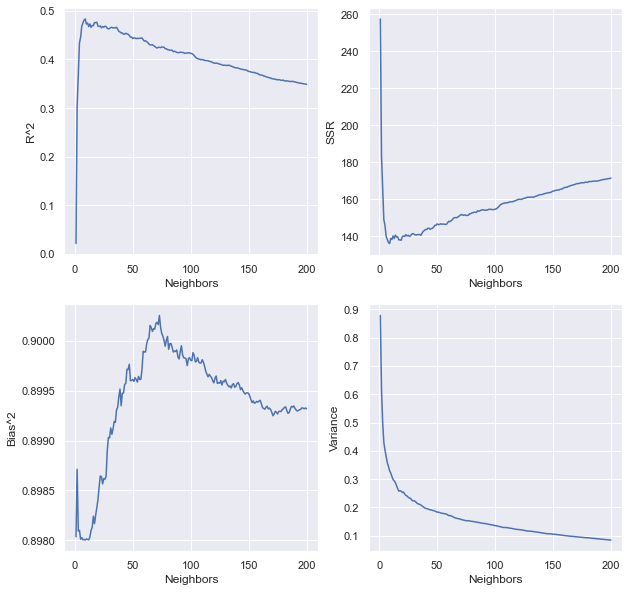

In [5]:
df_knn_ed = tuning_knn(200)

##### MIglior previsione

Neighbors      9.000000
R^2            0.483074
SSR          136.010648
Bias^2         0.898001
Variance       0.329793
Name: 8, dtype: float64


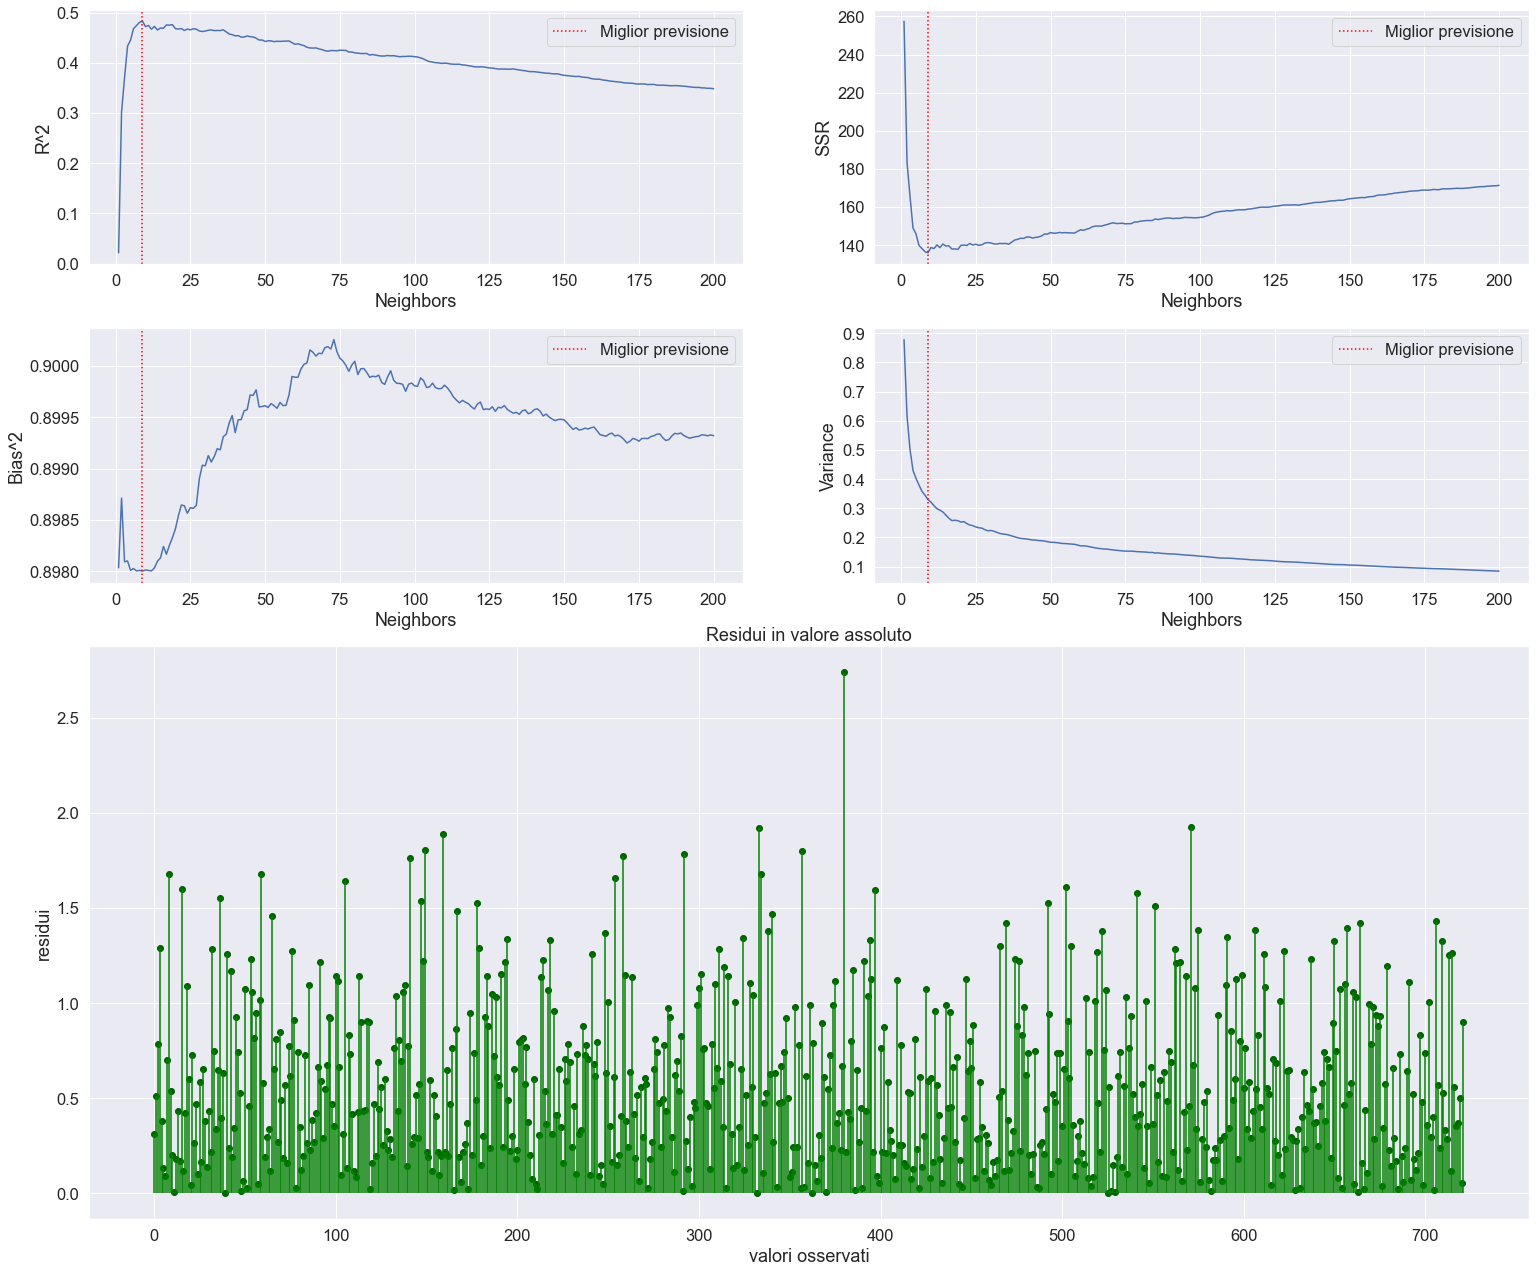

In [6]:
summary_knn_best(df_knn_ed)

<a id="2.1.2"/></a>
#### 2 Funzione MinKowski con manhattan_distance
$\sum(x-y)^2$

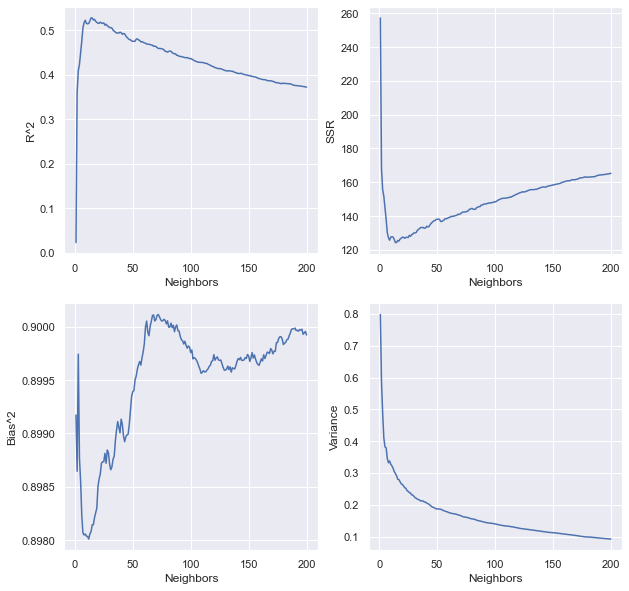

In [7]:
df_knn_md = tuning_knn(200, 1)

##### MIglior previsione

Neighbors     14.000000
R^2            0.527604
SSR          124.294128
Bias^2         0.898078
Variance       0.298331
Name: 13, dtype: float64


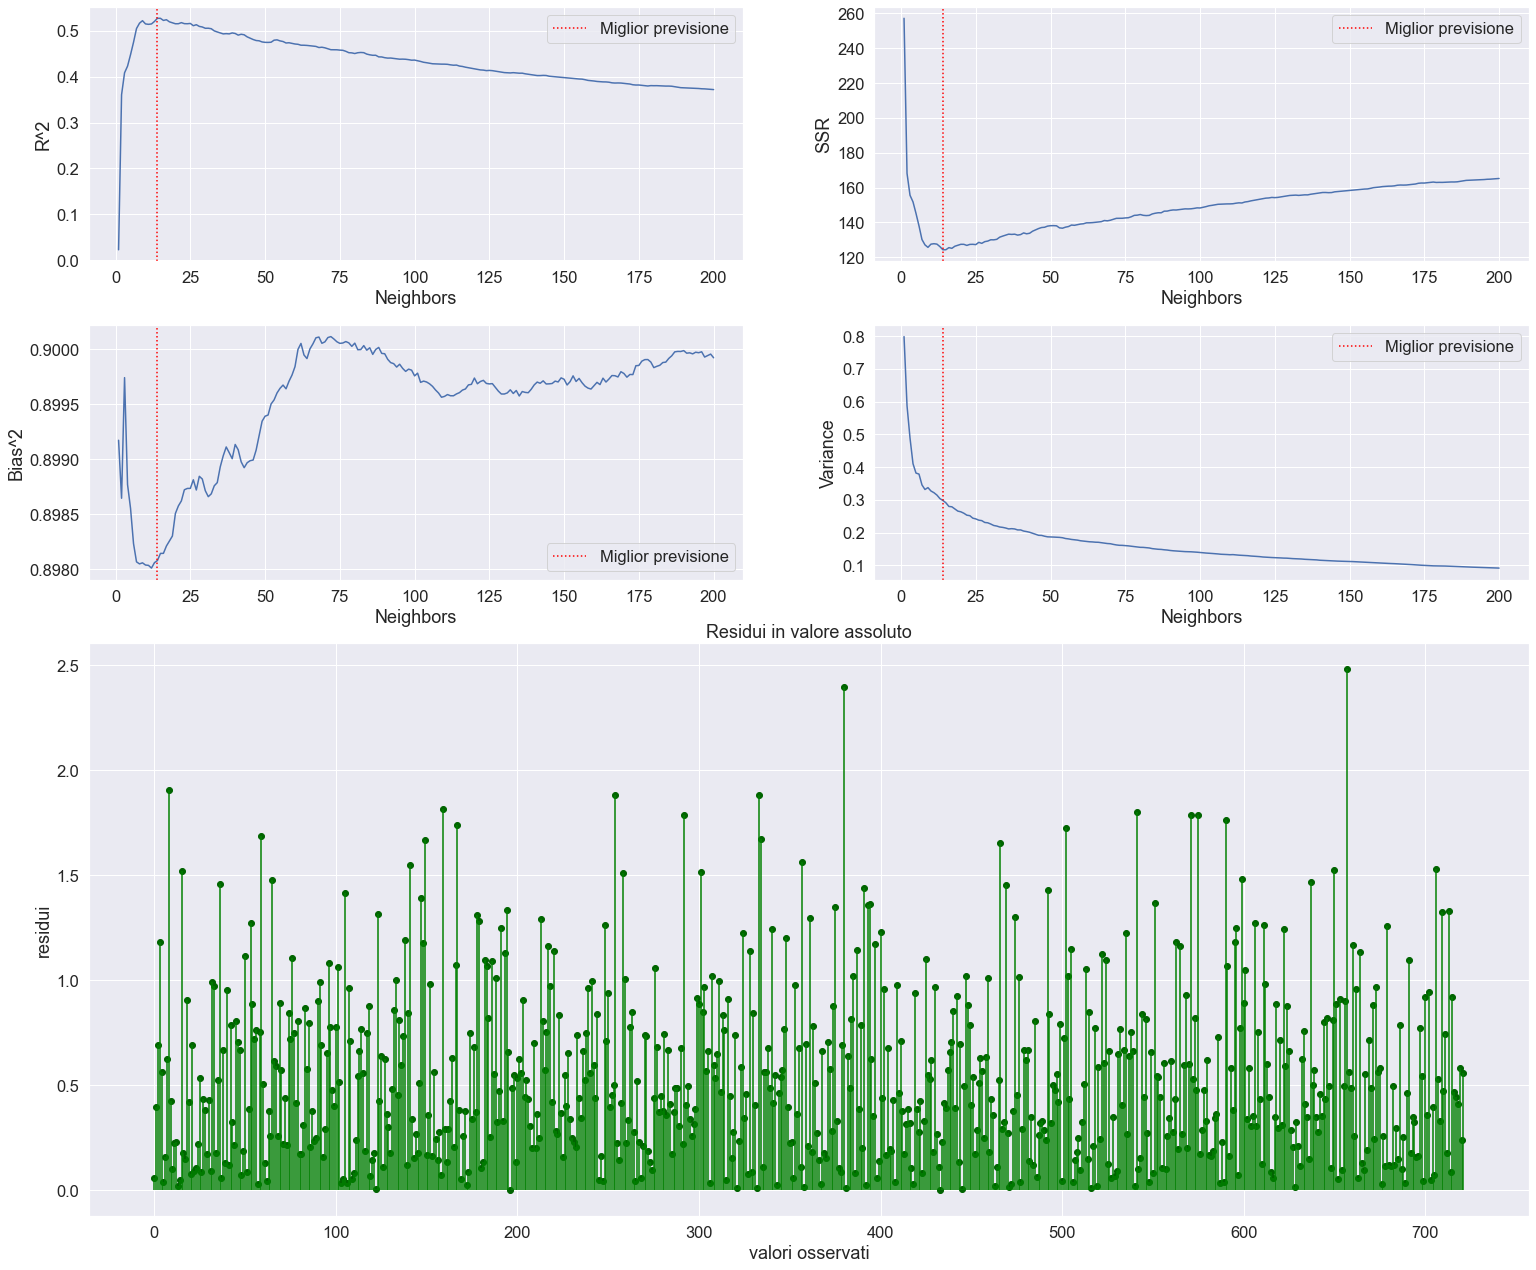

In [8]:
summary_knn_best(df_knn_md, 1)

<a id="2.1.3"/></a>
#### 3 Funzione Cosine distance
$
\cos(A,B)= \frac{A \cdot B}{\|A\| \|B\|} = \frac{\sum_i A_i B_i}{\sqrt{\sum_i A_i^2}\sqrt{\sum_i B_i^2}}
$

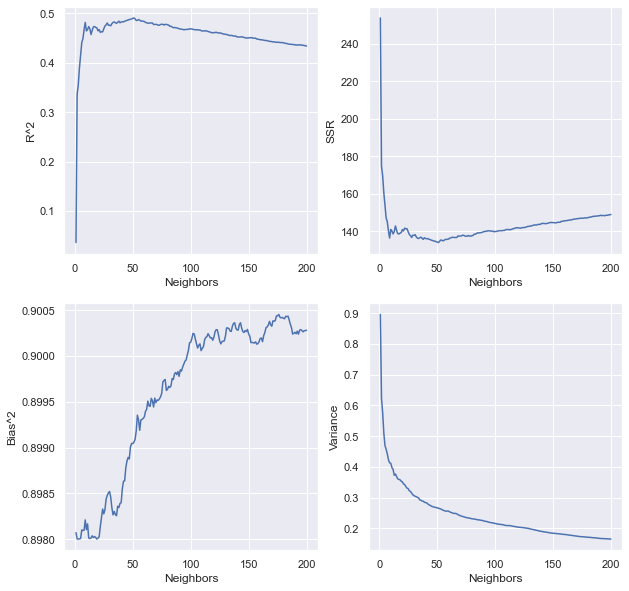

In [9]:
cosine_distance = lambda a, b : abs((np.dot(a,b)/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))) - 1) #funzione di similarità
 #NB : c'è quel -1 nella funzione perchè a e b sono simili quando arrivano vicino a 1 ed essendo che con questa funzione
 #     trovo la distanza tra punti ho messo -1 cosi se sono uguale mi da zero
df_knn_cd = tuning_knn(200, custom_fun = cosine_distance)

##### MIglior previsione

Neighbors     51.000000
R^2            0.490738
SSR          133.993913
Bias^2         0.899060
Variance       0.266323
Name: 50, dtype: float64


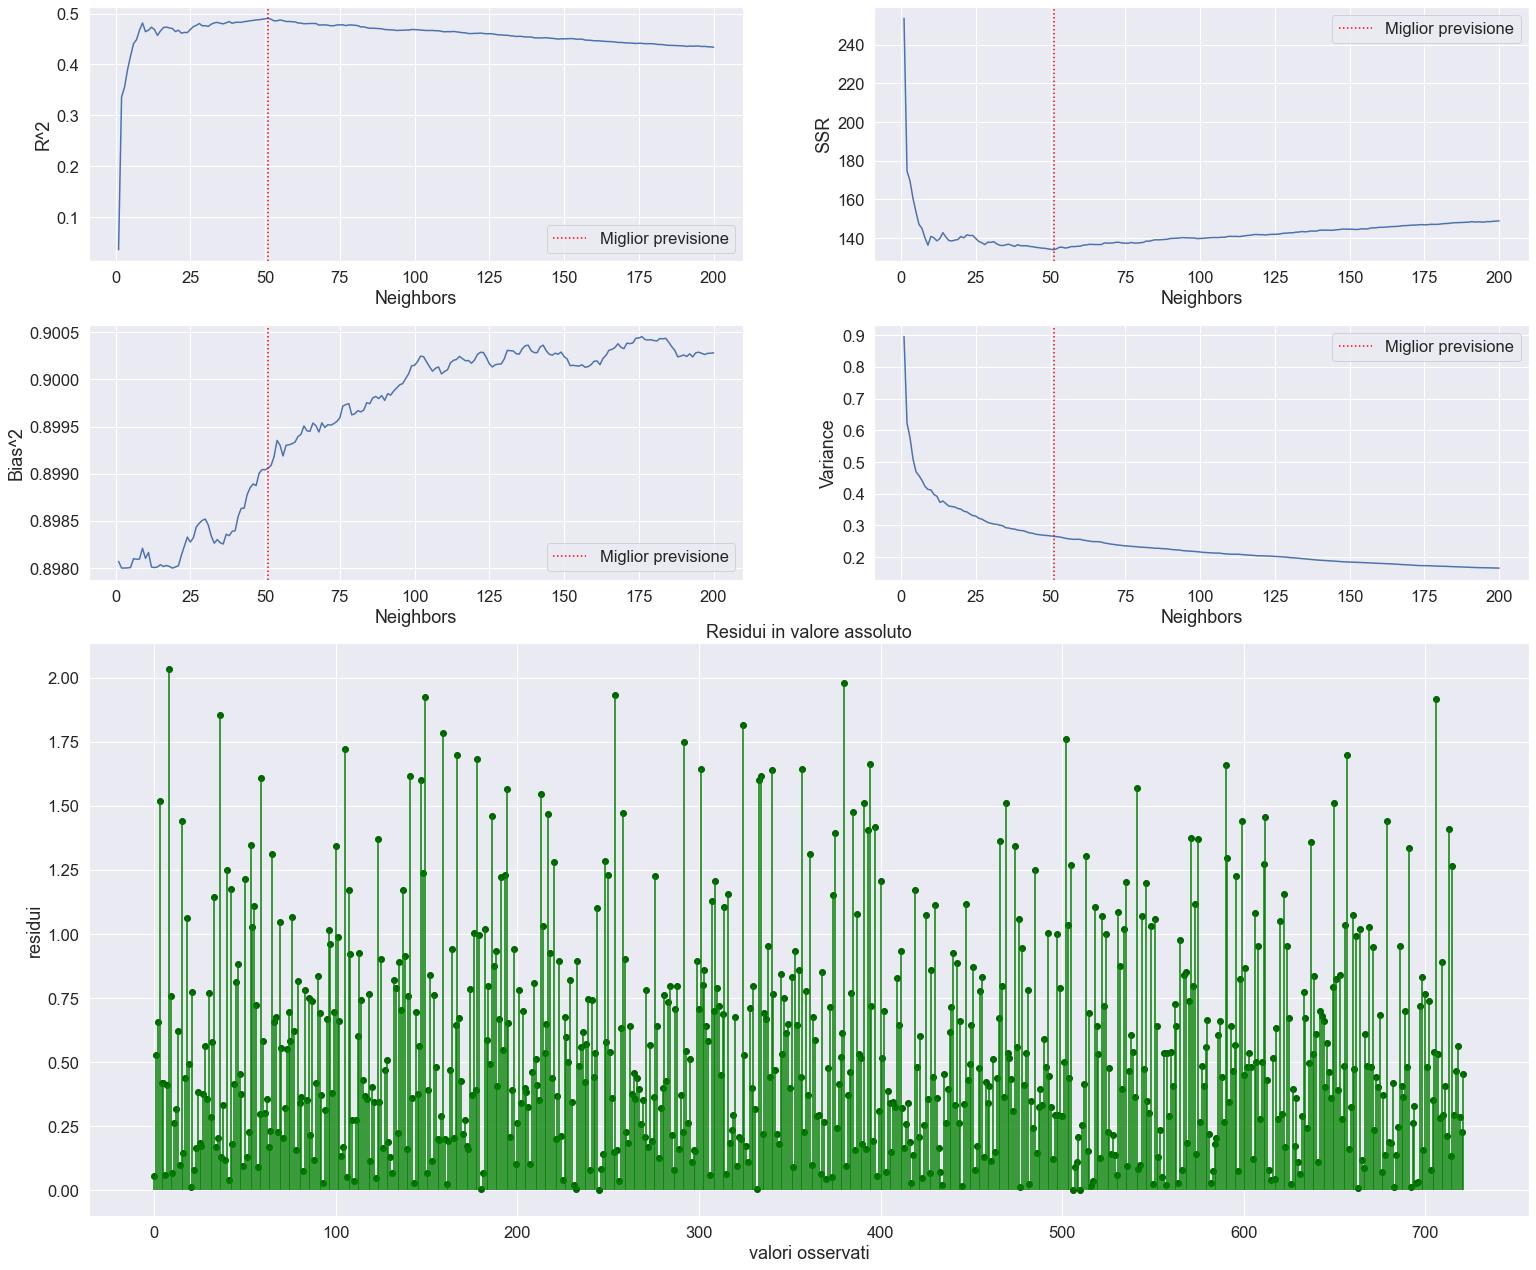

In [10]:
summary_knn_best(df_knn_cd, custom_fun = cosine_distance)

<a id="2.2"/></a>
### 2 Regressione lineare

In [11]:
# creo nuove feature per modificare anche il coefficiente angolare date delle dummy variable
def modify_coef_ang_for_dummy():
    #predittori che non sono dummy variable
    predict_not_dummy = ["LAMBDArevenue","LOGbudget","LOGpopularity","release_year","release_month",
                         "num_Keywords","num_cast","num_production_companies","num_crew","num_spoken_languages"]
    dummy = df[df.columns.difference(predict_not_dummy)] #df con le variabili dummy
    predict_not_dummy.remove("LAMBDArevenue")
    var = df[predict_not_dummy] #df con i predittori NON dummy
    df_coef = pd.DataFrame() # nuovo dataframe con le varie combinazioni
    for col in var: #creo una colonna con predittore * dummy variable
        for col_dummy in dummy:
            df_temp = pd.DataFrame(dummy[col_dummy] * var[col], columns = ["COEFANG_"+col+"_AND_"+col_dummy])
            df_coef = pd.concat([df_coef,df_temp], axis = 1)
    return df_coef

# viene cercato il modello migliore, come nell'algoritmo step presente in R, 
# qui ho fatto uno step forward controllando il bic per un modello più parsimonioso
def choice_best_model(df_x):
    predi = [] # mi serve per sapere i predittori che utilizzati dal modello migliore
    columns_predictors = df_x[df_x.columns.difference(["LAMBDArevenue"])].columns # questo mi serve per inserire i predittori
    fit = lm("LAMBDArevenue ~ 1", data = df_x).fit() # modello iniziale
    str_model = "LAMBDArevenue~" # stringa per creare il modello
    pos_predictor = 0 # mi serve nel caso ho raggiunto il modello migliore
    pos_of_choice_predictors = [] # mi ricorda quali predittori ho già preso dandomi l'indice, questo per non riprendere la stessa cosa
    total_predictors = 0 # mi serve per non sforare sul massimo dei predittori
    while pos_predictor != -1 and total_predictors < len(columns_predictors):
        print(fit.summary())
        print("\n\n ___________________________________________________________________________________________________________ \n\n")
        total_predictors += 1 #incremento dei predittori scelti per il modello
        pos_predictor = -1 # do per ipotesi che il modello che ho sia il migliore
        actual_bic = fit.bic #BIC del modello che sto verificando
        for pos, predict in enumerate(columns_predictors): #serve per trovare il miglior predittore da aggiungere
            if pos not in pos_of_choice_predictors: # se questo predittore non è già stato scelto
                if str_model[-1] == "~": #caso aggiunta del primo predittore
                    fit_temp = lm(str_model + predict, data = df_x).fit() #modello che sto provando
                else:
                    fit_temp = lm(str_model + "+" + predict, data = df_x).fit() #modello che sto provando
                if fit_temp.bic < actual_bic: #caso in cui il bic del nuovo modello è inferiore al modello attuale
                    pos_predictor = pos
                    actual_bic = fit_temp.bic
        if pos_predictor != -1: #caso in cui ho un modello migliore del mio
            predi.append(columns_predictors[pos_predictor])
            pos_of_choice_predictors.append(pos_predictor) #aggiornamento predittori utilizzati
            str_model += "+" + columns_predictors[pos_predictor] #aggiornamento modello 
            fit = lm(str_model, data = df_x).fit() #calcolo del modello aggiornato
    return fit, predi

def summary_of_model(fit_model, predictor):
    lr = LinearRegression()
    lr.fit(train[predictor], train["LAMBDArevenue"])
    print(f" R^2 : {lr.score(test[used_predictors], test['LAMBDArevenue'])}\n",
          f"SSR : {sum((lr.predict(test[used_predictors]) - test['LAMBDArevenue'])**2)}")
    sb.set(font_scale = 1.5)
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici, 4 righe e 4 colonne
    ax0 = fig.add_subplot(gs[0:2, 0:2]) #creo asse per primo grafico
    ax1 = fig.add_subplot(gs[0:2, 2:]) #creo asse per secondo grafico
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    # 1° grafico verifica della distorsione e di correlazione tra gli errori
    sb.scatterplot(x = fit_model.fittedvalues, y = fit_model.resid, ax = ax0)
    ax0.axhline(y = 0, color = "red", linestyle = ":")
    ax0.set_title("Verifica distorsione, varianza e correlazione degli errori")
    ax0.set(xlabel="valori osservati", ylabel = "residui")
    # 2° grafico verifica di normalità
    stats.probplot(best_fit.fittedvalues, plot=ax1)
    ax1.set_title("Verifica normalità")
    l_residual = abs(lr.predict(test[predictor]) - test["LAMBDArevenue"])
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale

In [12]:
trasf = StandardScaler()
df_reg = pd.concat([df,modify_coef_ang_for_dummy()], axis = 1)
df_p = pd.DataFrame(columns = df_reg.columns, data = trasf.fit_transform(df_reg)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
train = pd.concat([x_train,y_train], axis = 1)
test = pd.concat([x_test,y_test], axis = 1)

<a id="2.2.1"/></a>
#### 1 Ricerca modello ottimale

In [13]:
best_fit, used_predictors = choice_best_model(train)

                            OLS Regression Results                            
Dep. Variable:          LAMBDArevenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 04 Dec 2020   Prob (F-statistic):                nan
Time:                        13:18:27   Log-Likelihood:                -2075.0
No. Observations:                1465   AIC:                             4152.
Df Residuals:                    1464   BIC:                             4157.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0084      0.026     -0.322      0.7

                            OLS Regression Results                            
Dep. Variable:          LAMBDArevenue   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     413.7
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          2.31e-238
Time:                        13:18:47   Log-Likelihood:                -1519.9
No. Observations:                1465   AIC:                             3050.
Df Residuals:                    1460   BIC:                             3076.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:          LAMBDArevenue   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     235.1
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          7.79e-256
Time:                        13:19:21   Log-Likelihood:                -1467.6
No. Observations:                1465   AIC:                             2953.
Df Residuals:                    1456   BIC:                             3001.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:          LAMBDArevenue   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     180.2
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          3.86e-262
Time:                        13:19:56   Log-Likelihood:                -1444.6
No. Observations:                1465   AIC:                             2913.
Df Residuals:                    1453   BIC:                             2977.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Quindi il modello ottimale trovato è: $$Y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \beta_4 x_{4i} + \beta_5 x_{5i} + \beta_6 x_{6i} + \beta_7 x_{7i} + \beta_8 x_{8i} + \beta_9 x_{9i} + \beta_{10} x_{10i} + \beta_{11} x_{11i} + \beta_{12} x_{12i} + \epsilon_i$$

_NB : Per verificare il modello migliore ho voluto utilizzare il BIC al posto del AIC, questo per ottenere un modello più parsimonioso e quindi mitigare l'overfitting_

<a id="2.2.2"/></a>
#### 2 Modello ottimale

 R^2 : 0.599607962899235
 SSR : 291.9694816643801


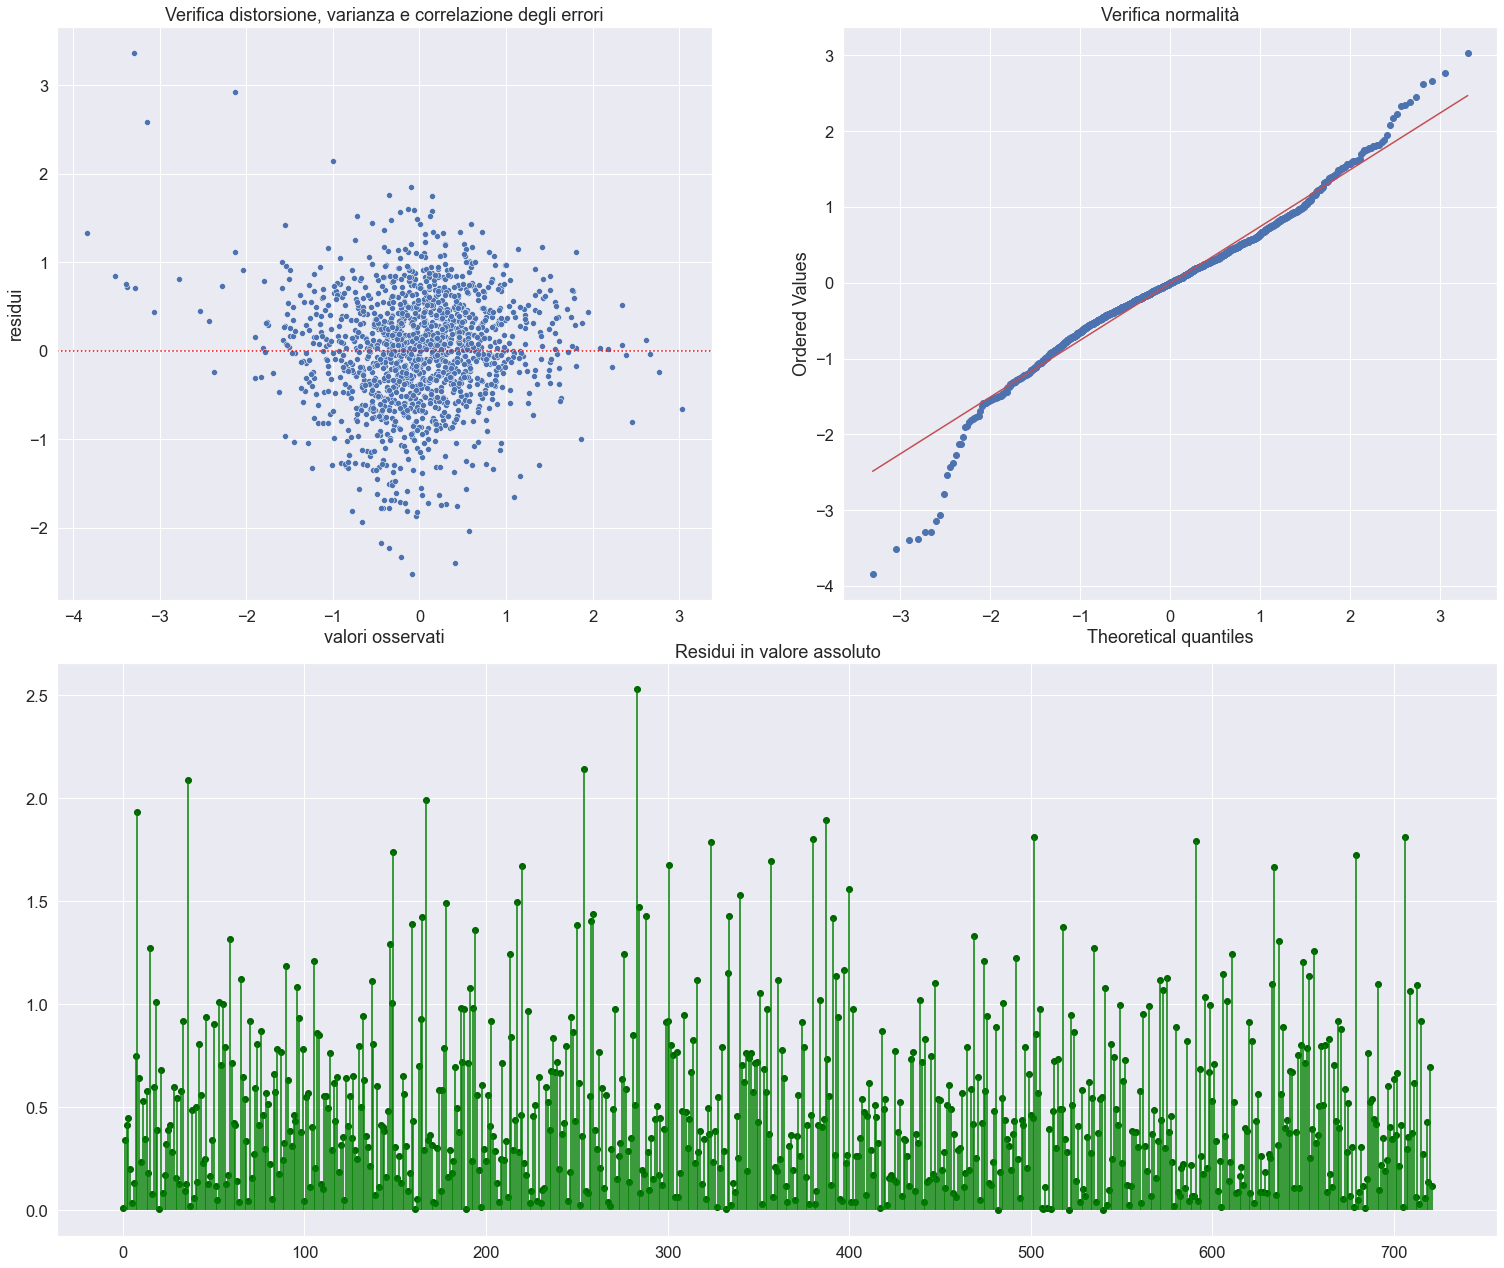

In [14]:
summary_of_model(best_fit, used_predictors)

Da questo grafico si evince:

- La distribuzione dei residui è intorno allo zero, $E[\epsilon|X = x] = 0$, quindi il modello è non distorto

- La varianza è sufficientemente costante, $Var[\epsilon|X = x] = \sigma^2$, quindi il modello è consistente

- Non c'è una correlazione evidente tra gli errori, $\forall_i = 1,\dots, n - 1 : \epsilon_i \neq \epsilon_{i + 1}$

- La maggior parte dei  punti nel grafico quantile-quantile cadono sopra la retta, quindi posso affermare l'ipotesi di normalità, $\hat{m}(x) \backsim N(\mu, \sigma^2)$

<a id="2.3"/></a>
### 3 Albero di decisione
Nel machine learning un albero di decisione è un modello predittivo, dove ogni nodo interno rappresenta una variabile, un arco verso un nodo figlio rappresenta un possibile valore per quella proprietà e una foglia il valore predetto per la variabile obiettivo a partire dai valori delle altre proprietà, che nell'albero è rappresentato dal cammino (path) dal nodo radice (root) al nodo foglia. Normalmente un albero di decisione viene costruito utilizzando tecniche di apprendimento a partire dall'insieme dei dati iniziali.

In [15]:
def tuning_dt(max_leaf, max_deep, criterion = "mse"):
    df_dt = pd.DataFrame(columns = ["Leaf", "Deep", "R^2", "SSR", "Bias^2", "Variance"]) # creo il df per tenere traccia del tuning
    for leaf in range(2, max_leaf + 1):
        for deep in range(1, max_deep + 1):
            dt = DecisionTreeRegressor(max_leaf_nodes = leaf, max_depth= deep, criterion = criterion)
            dt.fit(x_train, y_train)
            y_predict = dt.predict(x_validate)
            df_dt = df_dt.append({"Leaf" : leaf, "Deep" : deep,"R^2" : dt.score(x_validate, y_validate), "SSR" : sum((y_predict - y_validate)**2), 
                                  "Bias^2" : np.mean((np.mean(y_predict) - y_validate)**2), "Variance" : np.var(y_predict)}, ignore_index = True)
    #plotto i grafici riguardanti il tuning
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(10,10))
    for i, ax in enumerate(axs[0,]):#prima riga
        sb.lineplot(ax = ax, data = df_dt, x = "Leaf", y = df_dt.columns[i + 2])
    for i, ax in enumerate(axs[1,]):#seconda riga
        sb.lineplot(ax = ax, data = df_dt, x = "Deep", y = df_dt.columns[i + 2])
        #modifica la posizione dei sotto grafici
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)    
    return df_dt

def summary_dt_best(df_dt, criterion = "mse"):
    sb.set(font_scale = 1.5)
    print(df_dt.iloc[df_dt["R^2"].idxmax()]) #print del miglior tuning
    dt = DecisionTreeRegressor(max_leaf_nodes = int(df_dt.iloc[df_dt["R^2"].idxmax()]["Leaf"]), #istanzio l'algoritmo con i parametri migliori
                               max_depth= int(df_dt.iloc[df_dt["R^2"].idxmax()]["Deep"]), criterion = criterion)
    dt.fit(x_train, y_train)
    # creo il grafico per la miglior predizione
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici
    ax0 = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
           fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])] #creo asse per la prima riga
    ax1 = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
           fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3])] #creo asse per la seconda riga
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    for i, ax in enumerate(ax0): #prima riga
        sb.lineplot(ax = ax, data = df_dt, x = "Leaf", y = df_dt.columns[i + 2])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["Leaf"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    for i, ax in enumerate(ax1): #seconda riga
        sb.lineplot(ax = ax, data = df_dt, x = "Deep", y = df_dt.columns[i + 2])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["Deep"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    l_residual = abs(dt.predict(x_test) - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale

In [16]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

<a id="2.3.1"/></a>
#### 1 Funzione per la misura della qualità dello split : mse

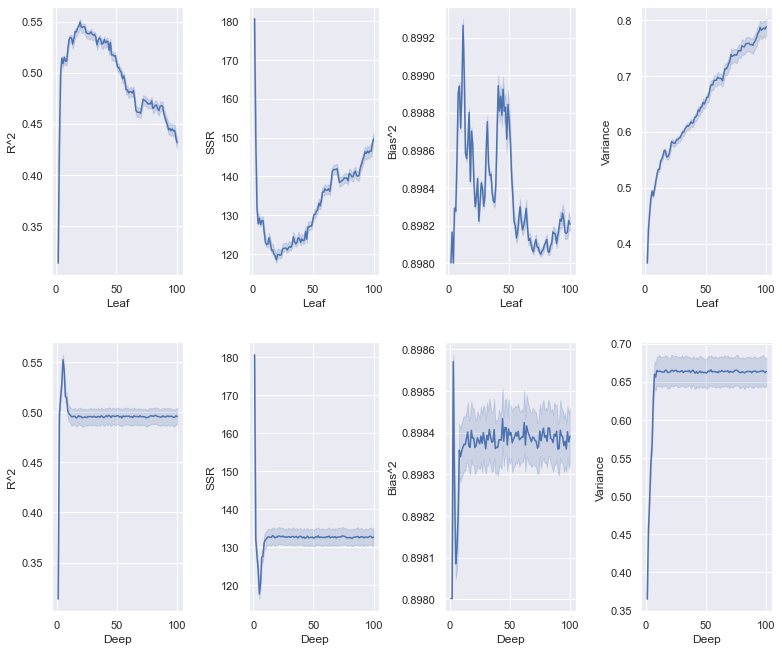

In [17]:
df_dt_mse = tuning_dt(100, 100)

##### Miglior previsione

Leaf         26.000000
Deep          5.000000
R^2           0.565098
SSR         114.428755
Bias^2        0.898052
Variance      0.590972
Name: 2404, dtype: float64


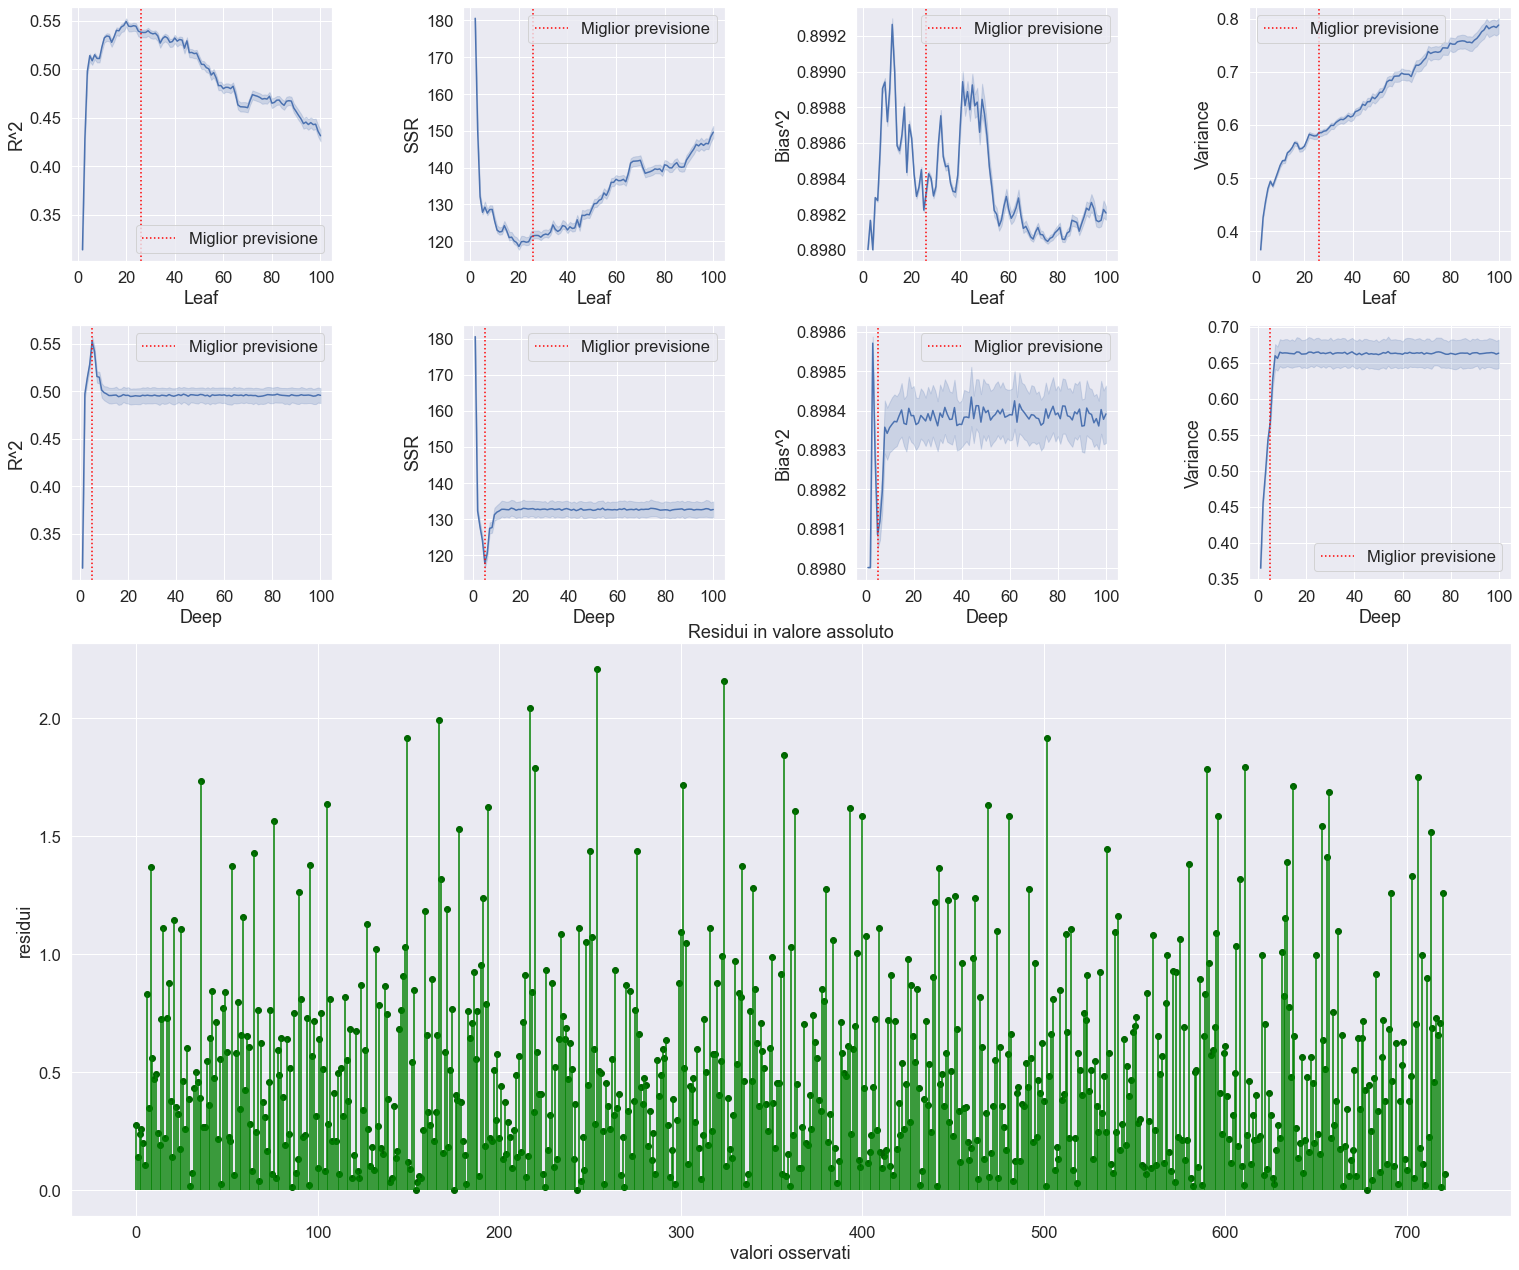

In [18]:
summary_dt_best(df_dt_mse)

<a id="2.3.2"/></a>
#### 2 Funzione per la misura della qualità dello split : mae

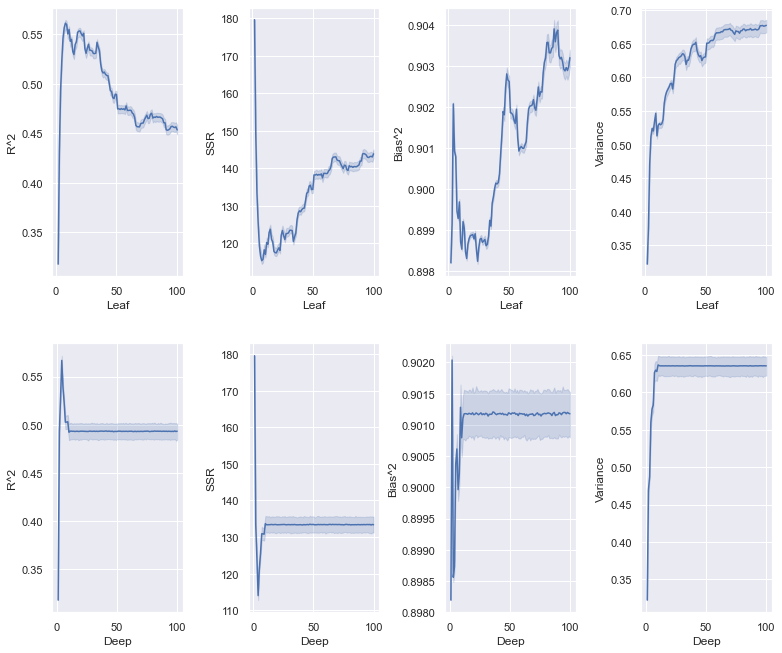

In [19]:
df_dt_mae = tuning_dt(100, 100, criterion = "mae")

##### Miglior previsione

Leaf         14.000000
Deep          4.000000
R^2           0.573192
SSR         112.299277
Bias^2        0.899183
Variance      0.572348
Name: 1203, dtype: float64


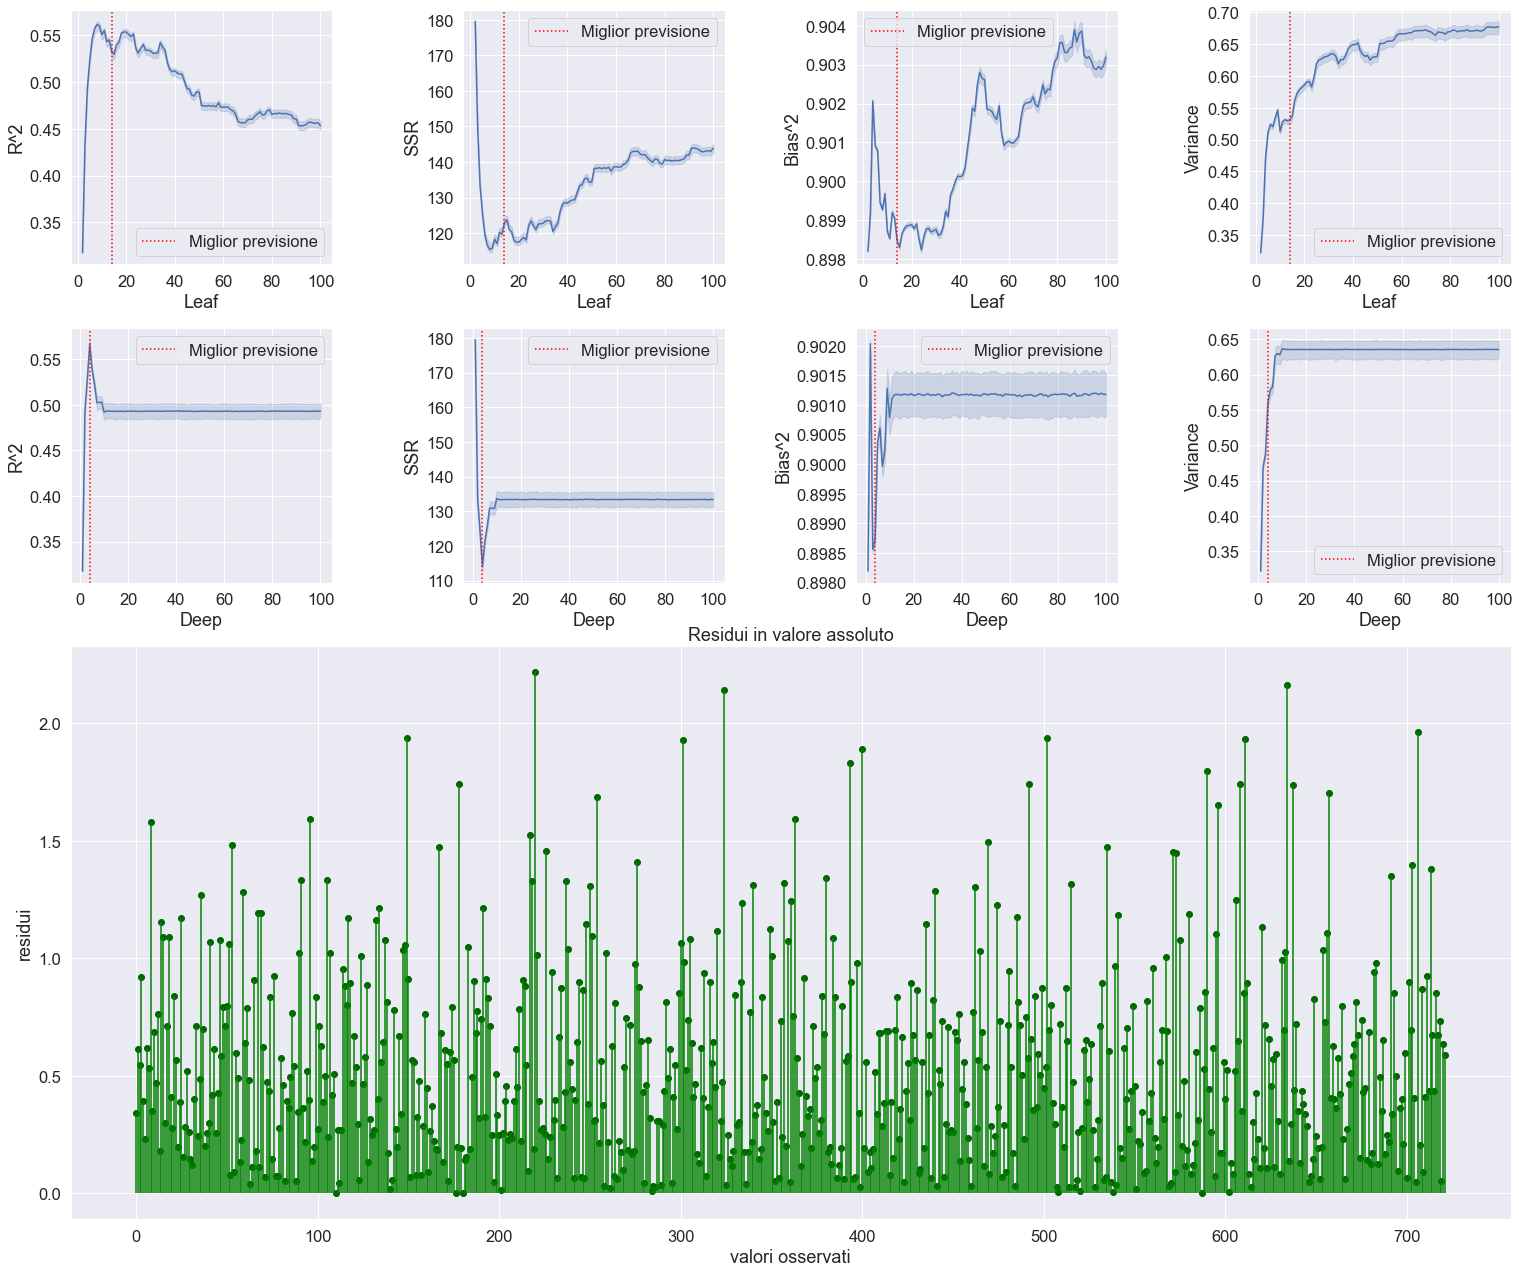

In [20]:
summary_dt_best(df_dt_mae, criterion = "mae")

<a id="2.3.3"/></a>
#### 3 Funzione per la misura della qualità dello split : friedman_mse

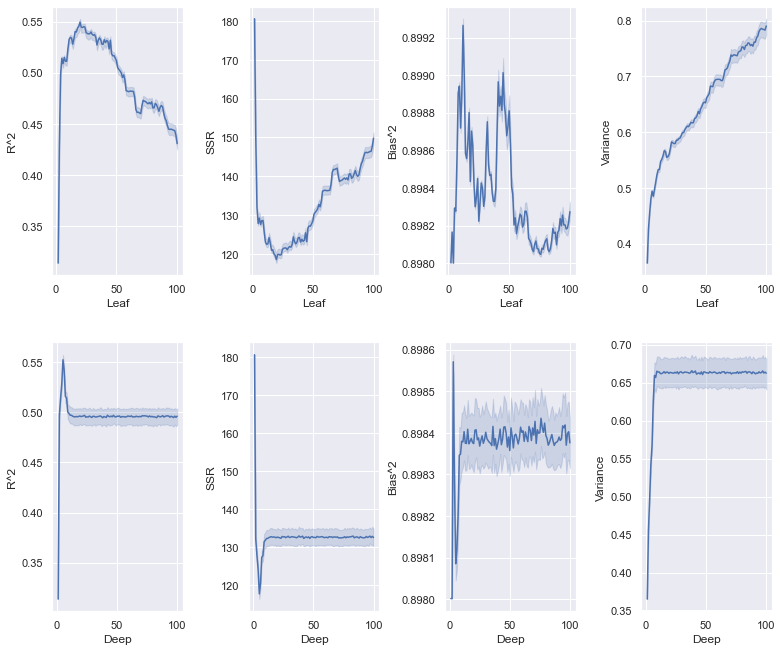

In [21]:
df_dt_fme = tuning_dt(100, 100, criterion = "friedman_mse")

##### Miglior previsione

Leaf         26.000000
Deep          5.000000
R^2           0.565098
SSR         114.428755
Bias^2        0.898052
Variance      0.590972
Name: 2404, dtype: float64


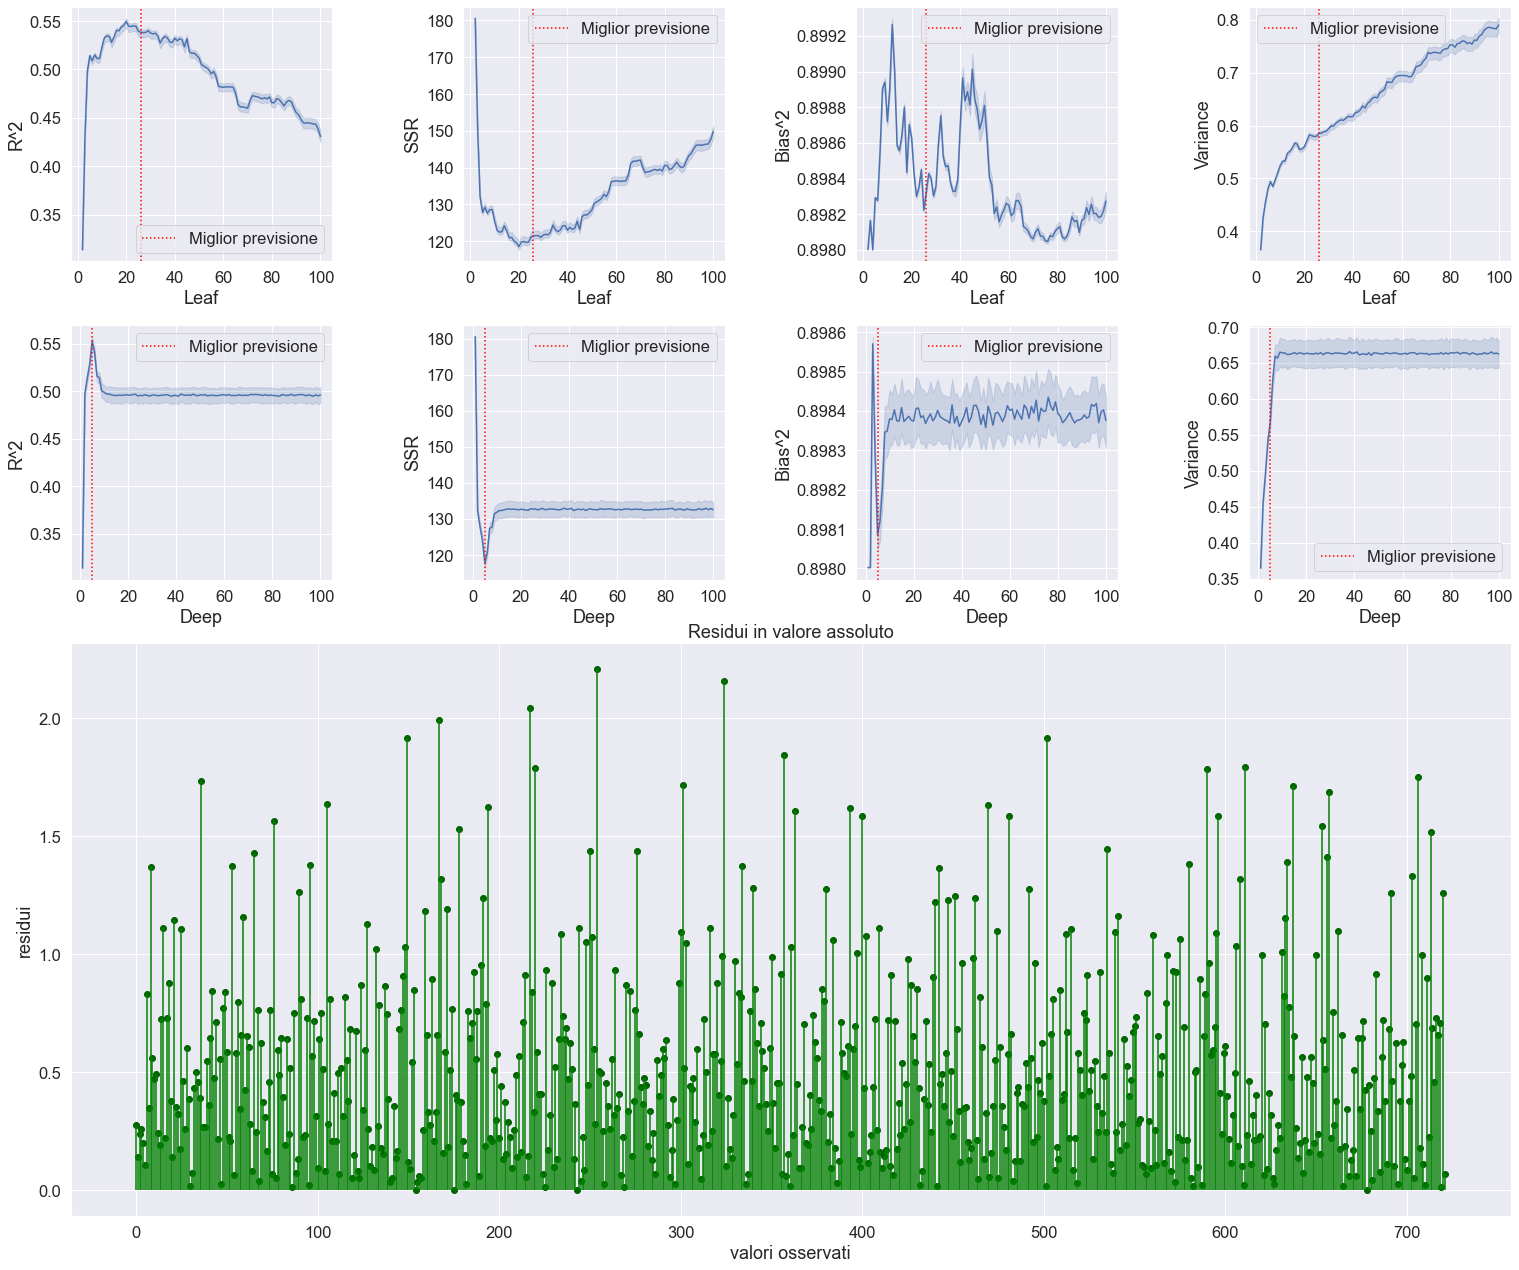

In [22]:
summary_dt_best(df_dt_fme, criterion = "friedman_mse")

<a id="2.4"/></a>
### 4 Bagging algorithm
Con il bagging si provvede a campionare ripetutamente il training set di input, con
distribuzione di probabilità uniforme e con reinserimento, per costruire ad ogni iterazione
un modello sul campione appena prodotto. Un campione di bootstrap è un campione casuale i cui elementi vengono estratti con reinserimento, per questo la tecnica prende anche
nome di bootstrap aggregating. Tutti gli insiemi costruiti ad ogni iterazione sono di taglia
uguale a quella del training set di partenza. Visto che si campiona con reinserimento, è
quindi possibile che in uno stresso insieme siano presenti elementi ripetuti e che elementi
del training set vengano omessi. E utile far notare che in media, e quando gli insiemi
sono abbastanza corposi, i training set costruiti contengono approssimativamente il 63.2%
dei record di quello iniziale.

In [23]:
def tuning_bagg(best_dt, n):
    df_dt = pd.DataFrame(columns = ["N modelli", "R^2", "SSR", "Bias^2", "Variance"]) #creo df
    for model in range(2, n + 1):
        bagg = BaggingRegressor(best_dt, n_estimators = model)
        bagg.fit(x_train, y_train)
        y_predict = bagg.predict(x_validate)
        df_dt = df_dt.append({"N modelli" : model, "R^2" : bagg.score(x_validate, y_validate), "SSR" : sum((y_predict - y_validate)**2), 
                              "Bias^2" : np.mean((np.mean(y_predict) - y_validate)**2), "Variance" : np.var(y_predict)}, ignore_index = True)
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
    for i, ax in enumerate(axs[0,]):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 1])
    for i, ax in enumerate(axs[1,]):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 3])
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25, # aggiusto la posizione dei sottografici
                        wspace=0.5)
    return df_dt

def summary_best_bagg(df_dt, best_dt):
    sb.set(font_scale = 1.5) #modifico la scala 
    print(df_dt.iloc[df_dt["R^2"].idxmax()])
    bagg = BaggingRegressor(best_dt, n_estimators = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]))
    bagg.fit(x_train, y_train)
    # plotto il miglior risultato
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici, 4 righe e 4 colonne
    ax0 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[0, 2:])] #creo asse per la prima riga
    ax1 = [fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[1, 2:])] #creo asse per la seconda riga
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    for i, ax in enumerate(ax0):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 1])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    for i, ax in enumerate(ax1):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 3])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    l_residual = abs(bagg.predict(x_test) - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale

In [24]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

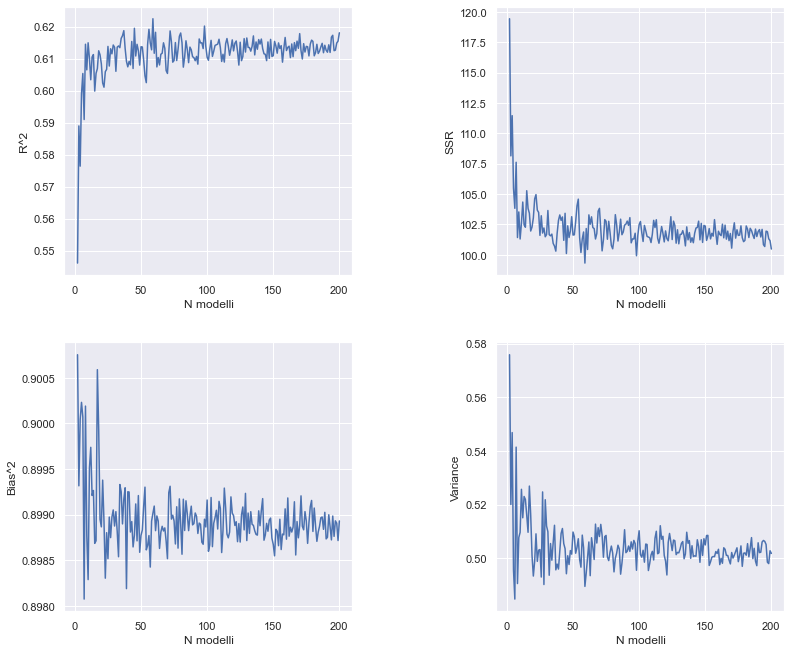

In [25]:
df_bagg = tuning_bagg(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), 200)

##### Miglior previsione

N modelli    59.000000
R^2           0.622508
SSR          99.323515
Bias^2        0.899016
Variance      0.489520
Name: 57, dtype: float64


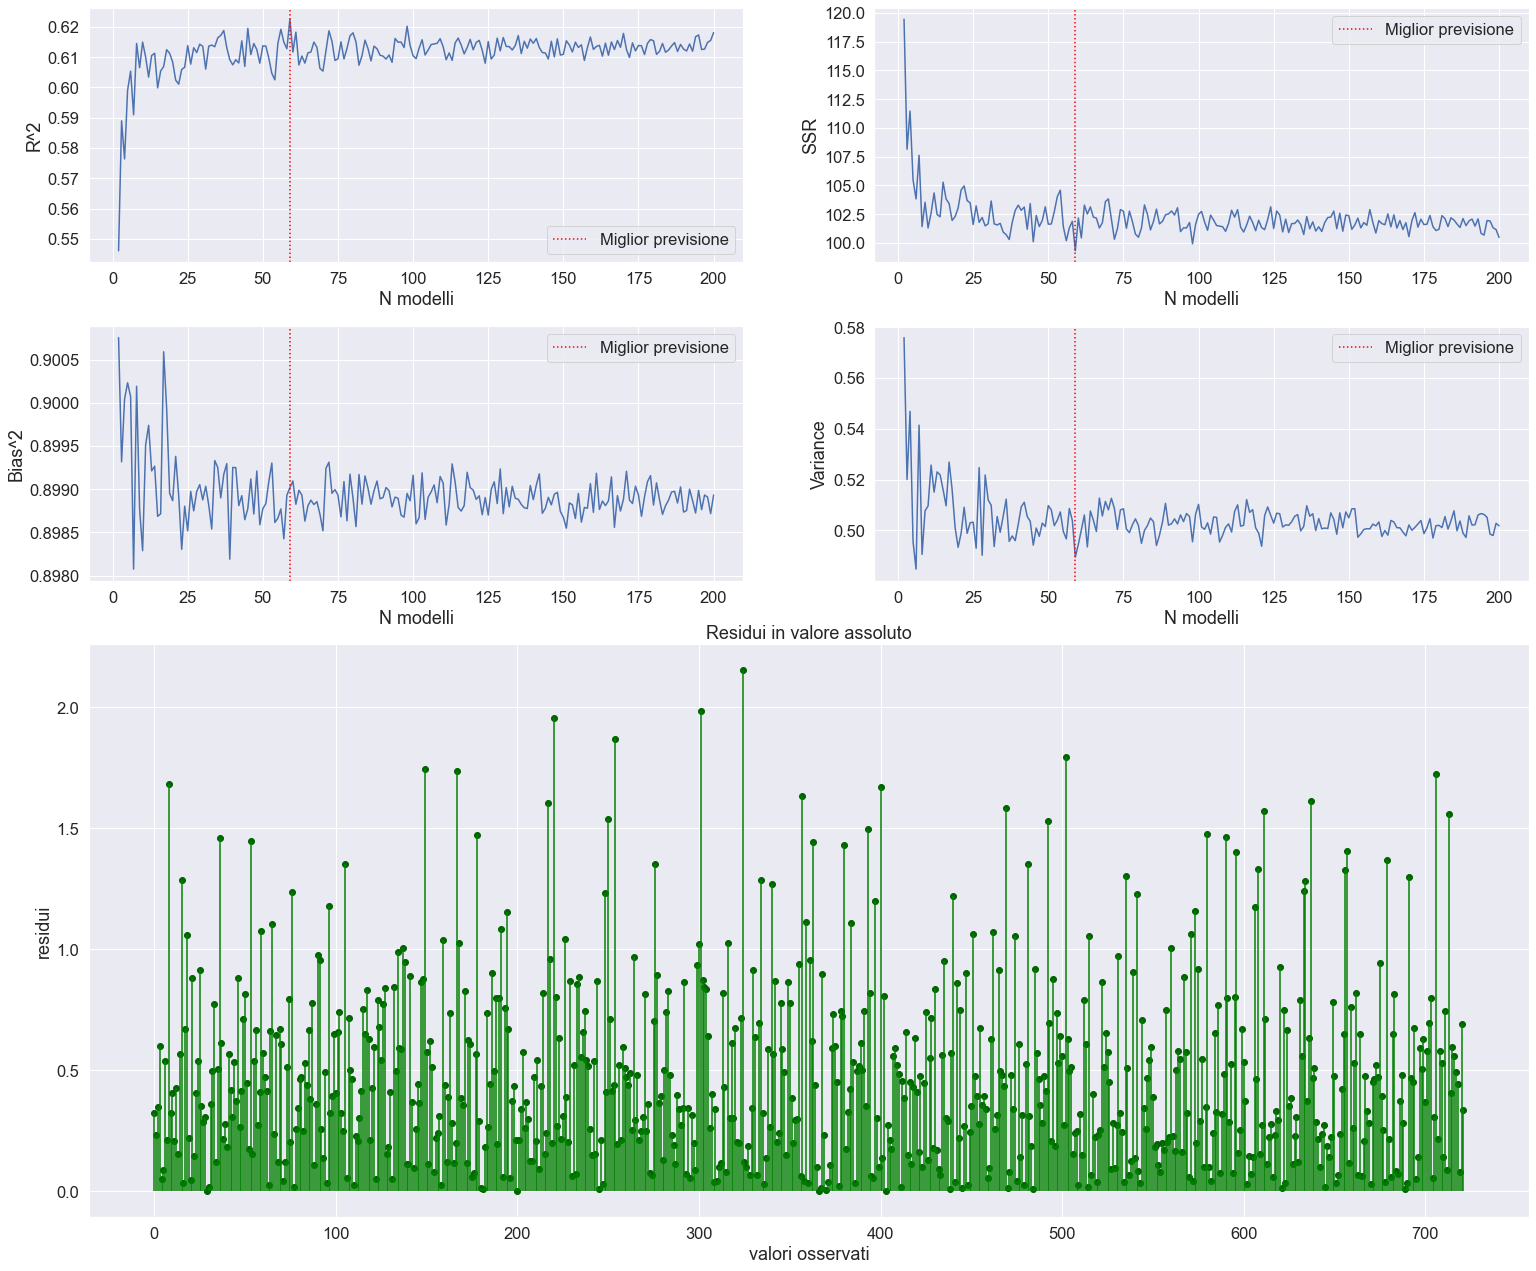

In [26]:
summary_best_bagg(df_bagg, DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"))

<a id="2.5"/></a>
### 5 AdaBoost
AdaBoost, abbreviazione di Adaptive Boosting, è un meta-algoritmo di apprendimento automatico. Può essere utilizzato insieme a molti altri tipi di algoritmi di apprendimento per migliorare le prestazioni. L'output degli altri algoritmi di apprendimento ("studenti deboli") viene combinato in una somma ponderata che rappresenta l'output finale del classificatore potenziato. AdaBoost è adattivo nel senso che i successivi studenti deboli vengono ottimizzati a favore di quelle istanze classificate erroneamente dai classificatori precedenti. AdaBoost è sensibile ai dati rumorosi e ai valori anomali

In [27]:
def tuning_ada(best_dt, n, loss = "linear"):
    df_dt = pd.DataFrame(columns = ["N modelli", "R^2", "SSR", "Bias^2", "Variance"]) #creo df
    for model in range(2, n + 1):
        ada = AdaBoostRegressor(best_dt, n_estimators = model, loss = loss)
        ada.fit(x_train, y_train)
        y_predict = ada.predict(x_validate)
        df_dt = df_dt.append({"N modelli" : model, "R^2" : ada.score(x_validate, y_validate), "SSR" : sum((y_predict - y_validate)**2), 
                              "Bias^2" : np.mean((np.mean(y_predict) - y_validate)**2), "Variance" : np.var(y_predict)}, ignore_index = True)
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
    for i, ax in enumerate(axs[0,]):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 1])
    for i, ax in enumerate(axs[1,]):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 3])
    return df_dt

def summary_best_ada(df_dt, best_dt, loss = "linear"):
    sb.set(font_scale = 1.5) #modifico la scala
    print(df_dt.iloc[df_dt["R^2"].idxmax()])
    ada = AdaBoostRegressor(best_dt, n_estimators = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), loss = loss)
    ada.fit(x_train, y_train)
    # plotto il miglior risultato
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici, 4 righe e 4 colonne
    ax0 = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[0, 2:])] #creo asse per la prima riga
    ax1 = [fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[1, 2:])] #creo asse per la seconda riga
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    for i, ax in enumerate(ax0):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 1])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    for i, ax in enumerate(ax1):
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 3])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    l_residual = abs(ada.predict(x_test) - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale

In [28]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

<a id="2.5.1"/></a>
#### 1 Funzione per l'aggiornamento dei pesi : linear

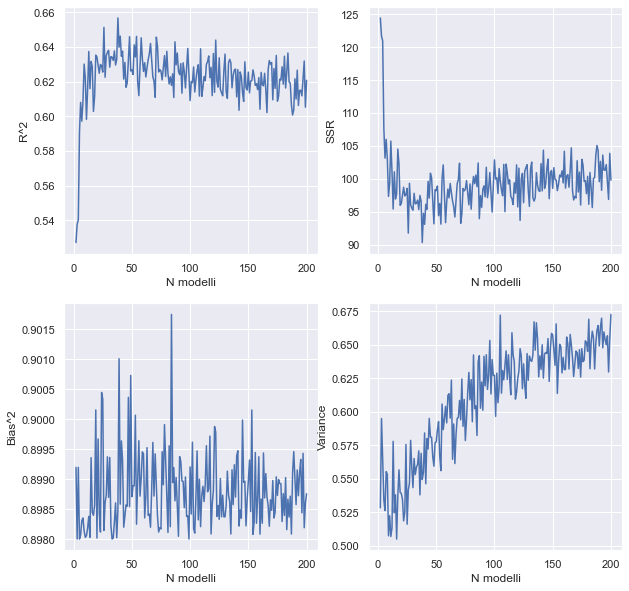

In [29]:
df_ada_l = tuning_ada(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), 200)

##### Miglior previsione

N modelli    38.000000
R^2           0.656699
SSR          90.327224
Bias^2        0.898476
Variance      0.549551
Name: 36, dtype: float64


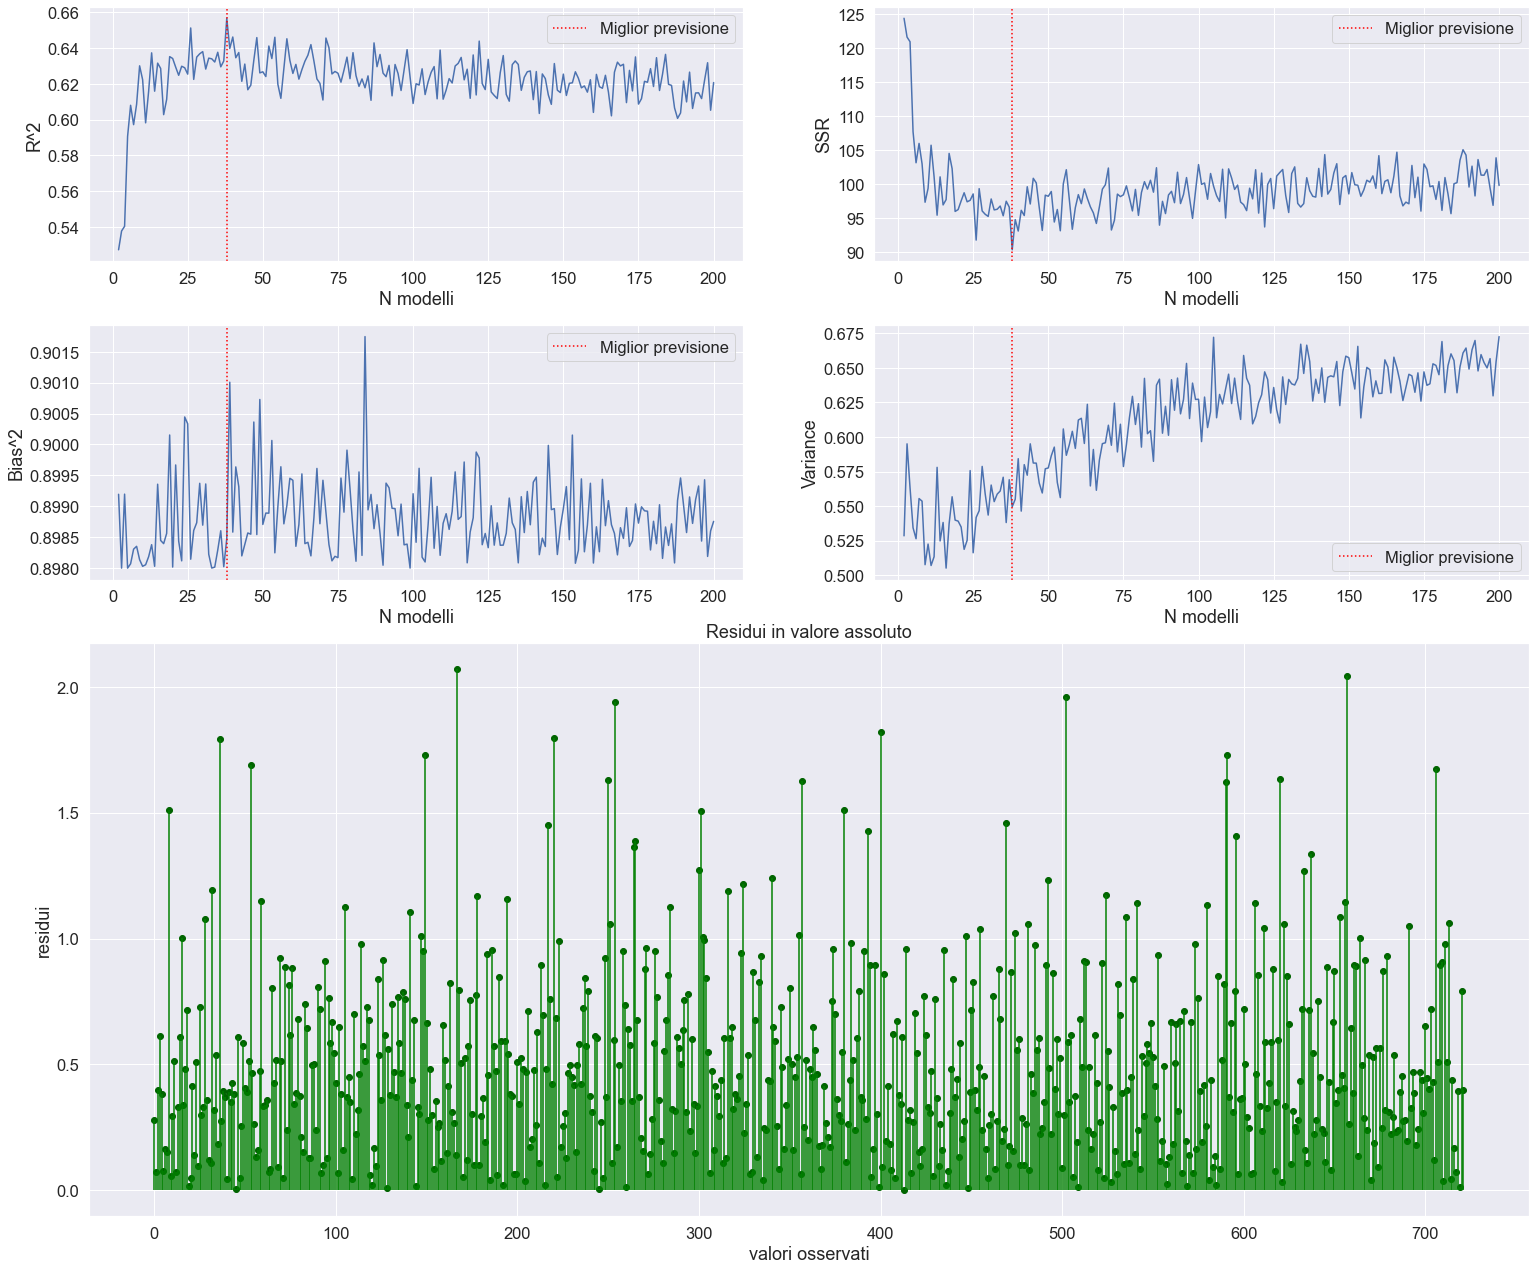

In [30]:
summary_best_ada(df_ada_l, DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"))

<a id="2.5.2"/></a>
#### 2 Funzione per l'aggiornamento dei pesi : square

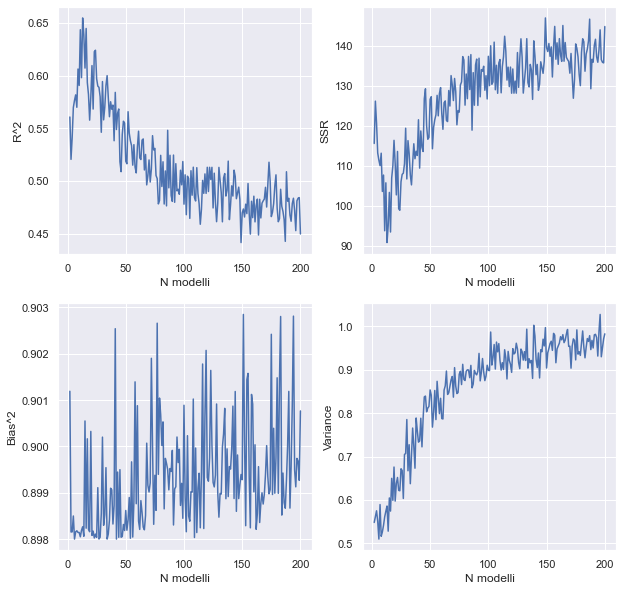

In [31]:
df_ada_s = tuning_ada(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), 200, loss = "square")

##### Miglior previsione

N modelli    13.000000
R^2           0.654763
SSR          90.836848
Bias^2        0.898266
Variance      0.585924
Name: 11, dtype: float64


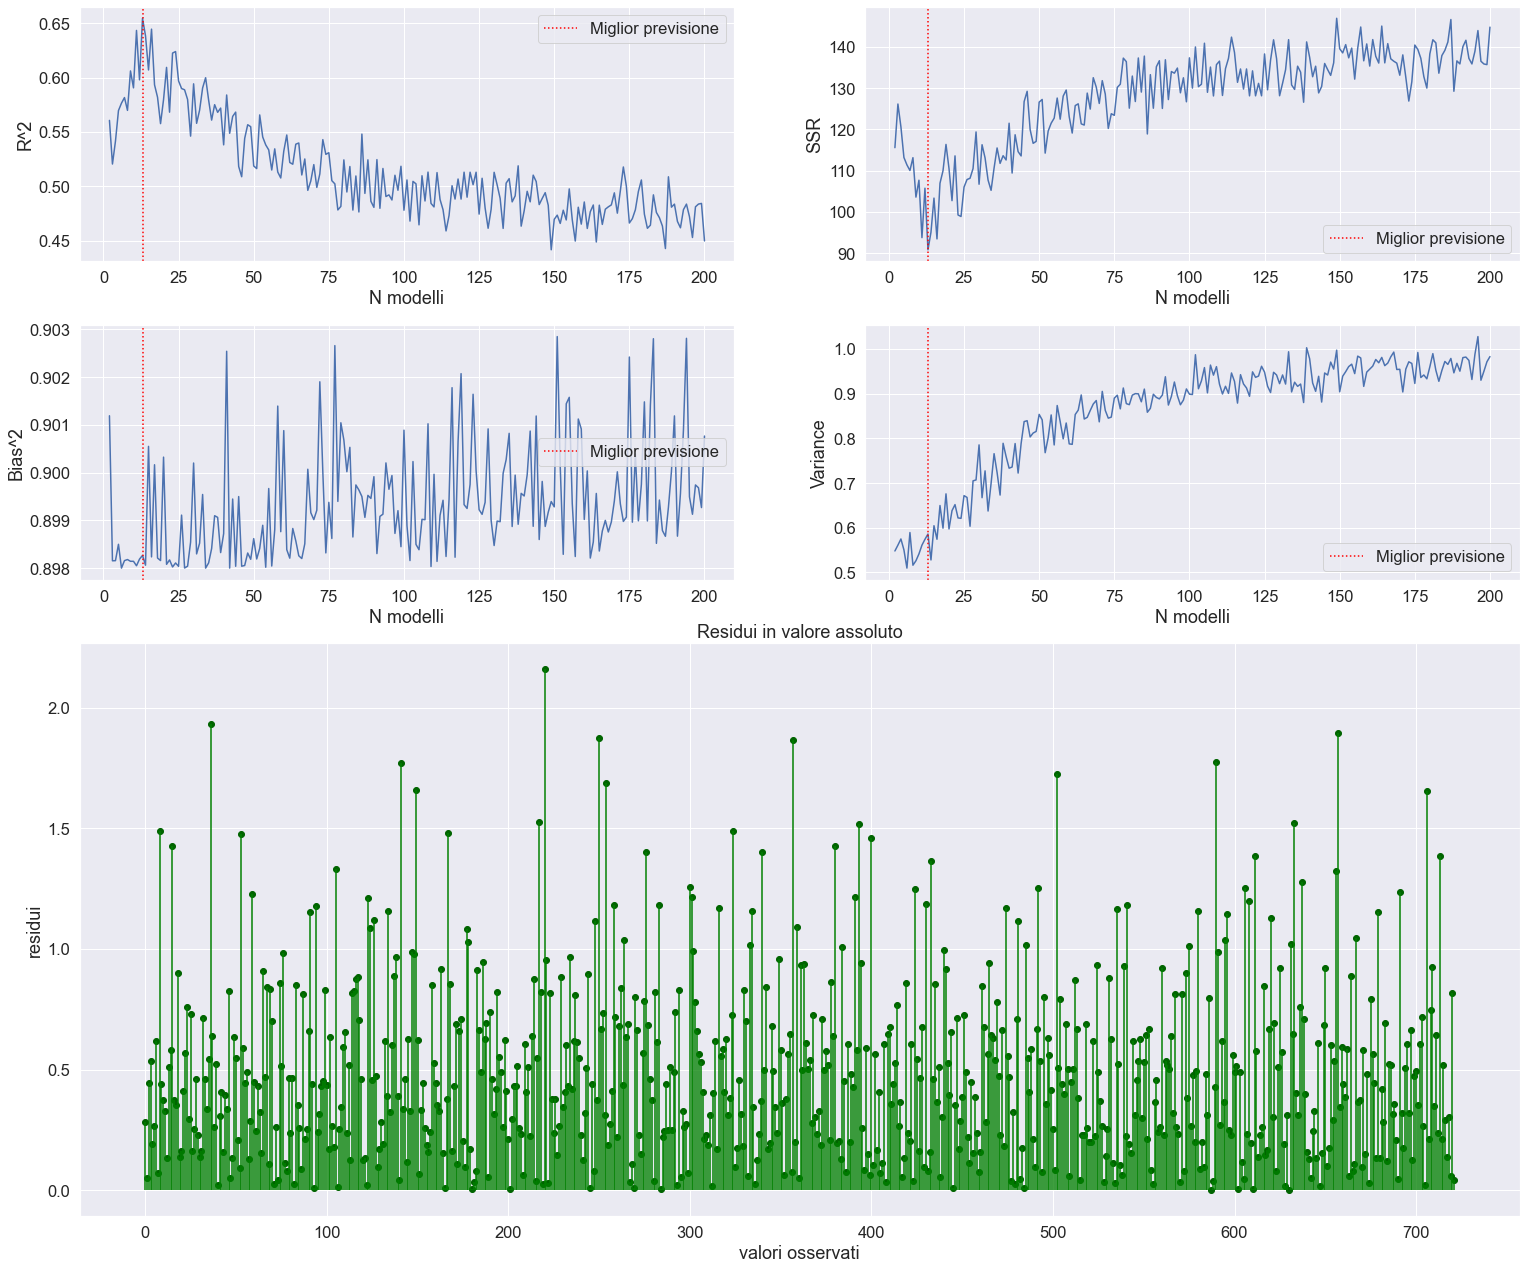

In [32]:
summary_best_ada(df_ada_s, DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), loss = "square")

<a id="2.5.3"/></a>
#### 3 Funzione per l'aggiornamento dei pesi : exponential

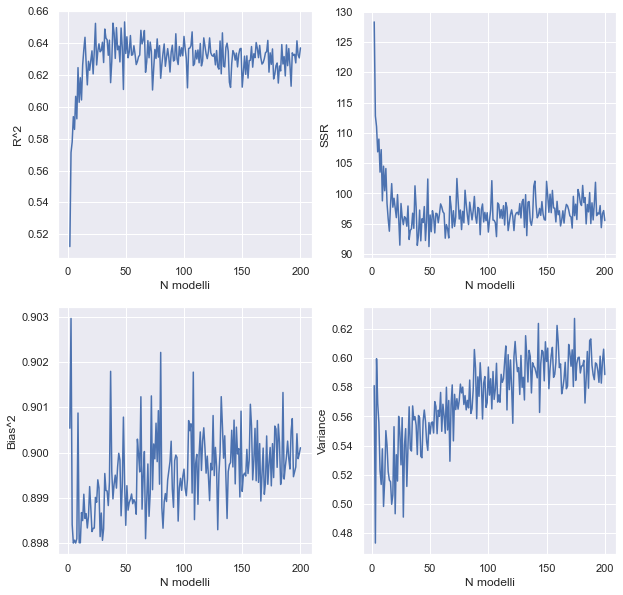

In [33]:
df_ada_e = tuning_ada(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), 200, loss = "exponential")

##### Miglior previsione

N modelli    49.000000
R^2           0.653239
SSR          91.237728
Bias^2        0.899348
Variance      0.555859
Name: 47, dtype: float64


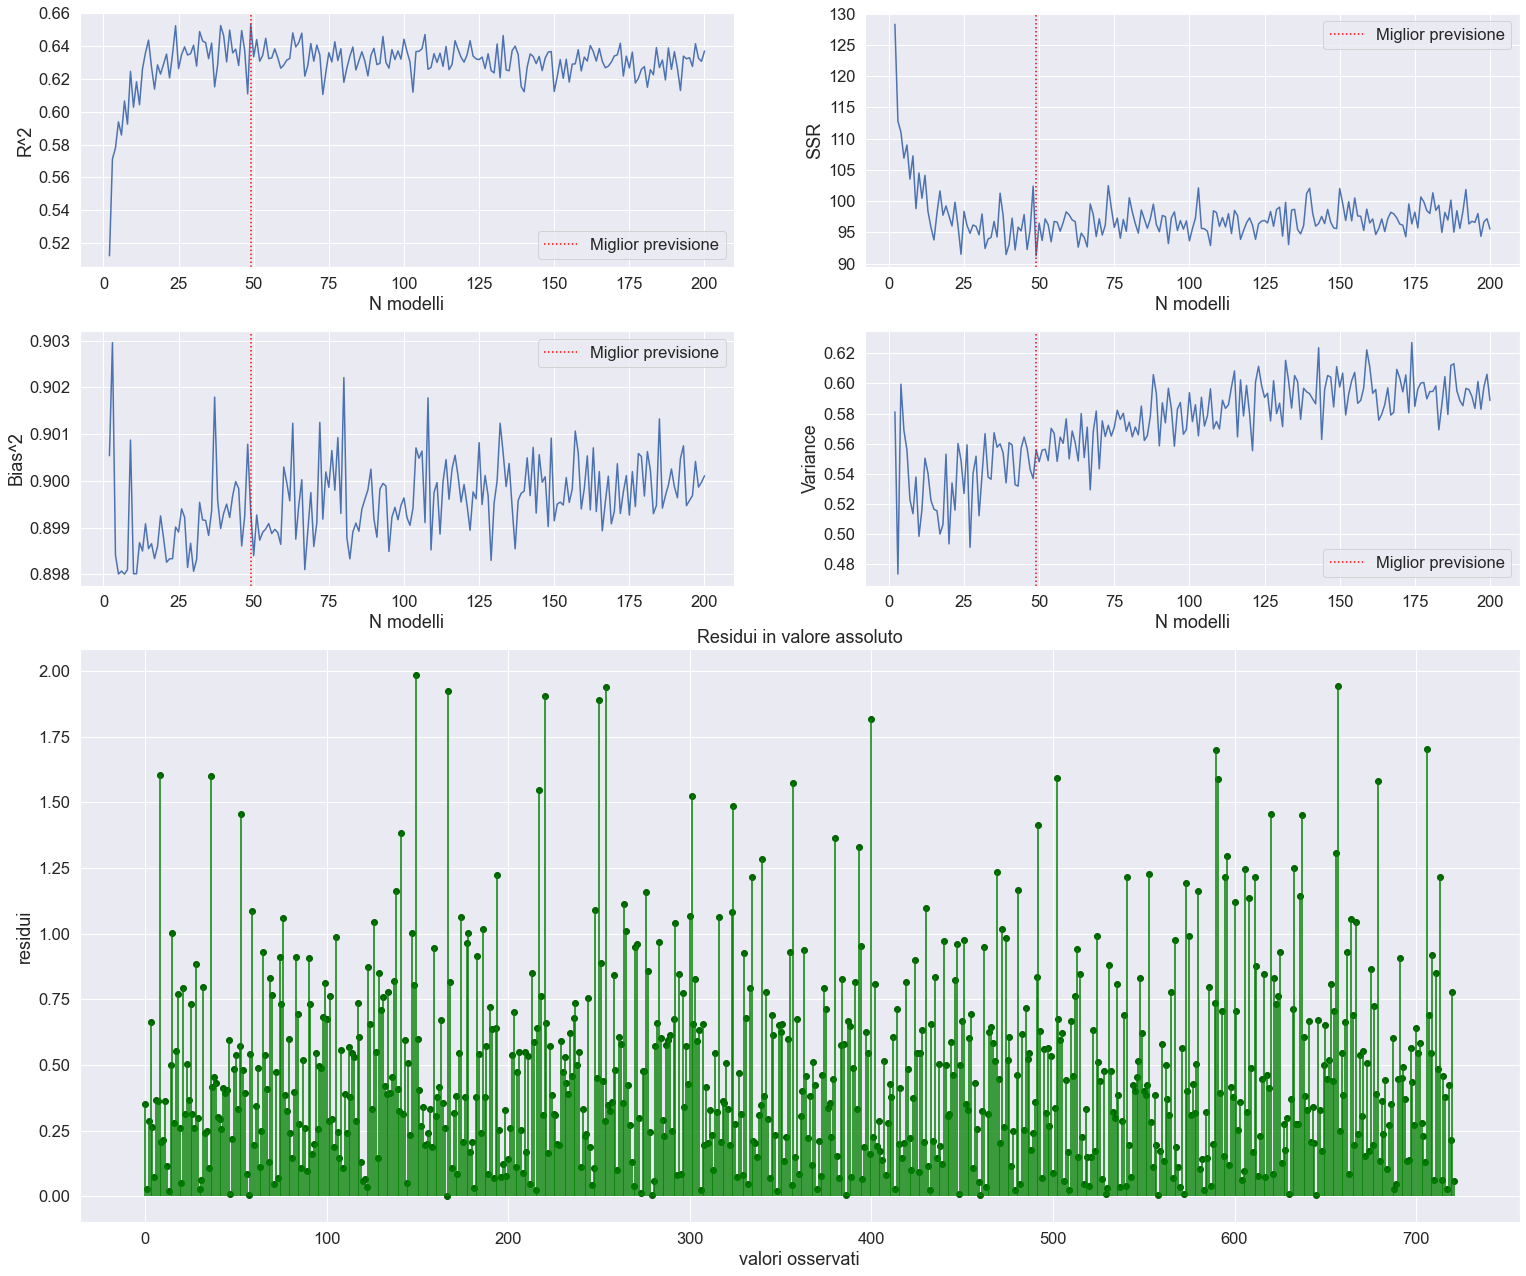

In [34]:
summary_best_ada(df_ada_e, DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"), loss = "exponential")

<a id="2.6"/></a>
### 6 Random forest
Rappresenta un tipo di modello ensemble, che si avvale del bagging come metodo di ensemble e l’albero decisionale come modello individuale.
Ciò significa che una foresta casuale combina molti alberi decisionali in un unico modello. Individualmente, le previsioni fatte dagli alberi decisionali potrebbero non essere accurate, ma combinate insieme, le previsioni saranno in media più vicine al risultato.
Il risultato finale restituito dal Random Forest per un problema di regressione altro non è che la media del risultato numerico restituito dai diversi alberi:

In [35]:
def tuning_rf(n, max_deep, criterion = "mse"):
    df_dt = pd.DataFrame(columns = ["N modelli", "Deep", "R^2", "SSR", "Bias^2", "Variance"]) # creo il df per tenere traccia del tuning
    for model in range(2, n + 1):
        for deep in range(1, max_deep + 1):
            rf = RandomForestRegressor(n_estimators = model, max_depth= deep, criterion = criterion)
            rf.fit(x_train, y_train)
            y_predict = rf.predict(x_validate)
            df_dt = df_dt.append({"N modelli" : model, "Deep" : deep,"R^2" : rf.score(x_validate, y_validate), "SSR" : sum((y_predict - y_validate)**2), 
                                  "Bias^2" : np.mean((np.mean(y_predict) - y_validate)**2), "Variance" : np.var(y_predict)}, ignore_index = True)
    #plotto i grafici riguardanti il tuning
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(10,10))
    for i, ax in enumerate(axs[0,]):#prima riga
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 2])
    for i, ax in enumerate(axs[1,]):#seconda riga
        sb.lineplot(ax = ax, data = df_dt, x = "Deep", y = df_dt.columns[i + 2])
        #modifica la posizione dei sotto grafici
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)    
    return df_dt

def summary_rf_best(df_dt, criterion = "mse"):
    sb.set(font_scale = 1.5) #modifico la scala
    print(df_dt.iloc[df_dt["R^2"].idxmax()]) #print del miglior tuning
    rf = RandomForestRegressor(n_estimators = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), #istanzio l'algoritmo con i parametri migliori
                               max_depth= int(df_dt.iloc[df_dt["R^2"].idxmax()]["Deep"]), criterion = criterion)
    rf.fit(x_train, y_train)
    # creo il grafico per la miglior predizione
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici
    ax0 = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
           fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])] #creo asse per la prima riga
    ax1 = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
           fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3])] #creo asse per la seconda riga
    axbig = fig.add_subplot(gs[2:, 0:]) #creo asse per il super grafico
    for i, ax in enumerate(ax0): #prima riga
        sb.lineplot(ax = ax, data = df_dt, x = "N modelli", y = df_dt.columns[i + 2])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["N modelli"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    for i, ax in enumerate(ax1): #seconda riga
        sb.lineplot(ax = ax, data = df_dt, x = "Deep", y = df_dt.columns[i + 2])
        ax.axvline(x = int(df_dt.iloc[df_dt["R^2"].idxmax()]["Deep"]), color = "red",
                   linestyle = ":", label = "Miglior previsione")
        ax.legend()
    l_residual = abs(rf.predict(x_test) - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #riporto la scala all'originale   

In [36]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.33, random_state = 42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

<a id="2.6.1"/></a>
#### 1 Funzione per la misura della qualità dello split : mse

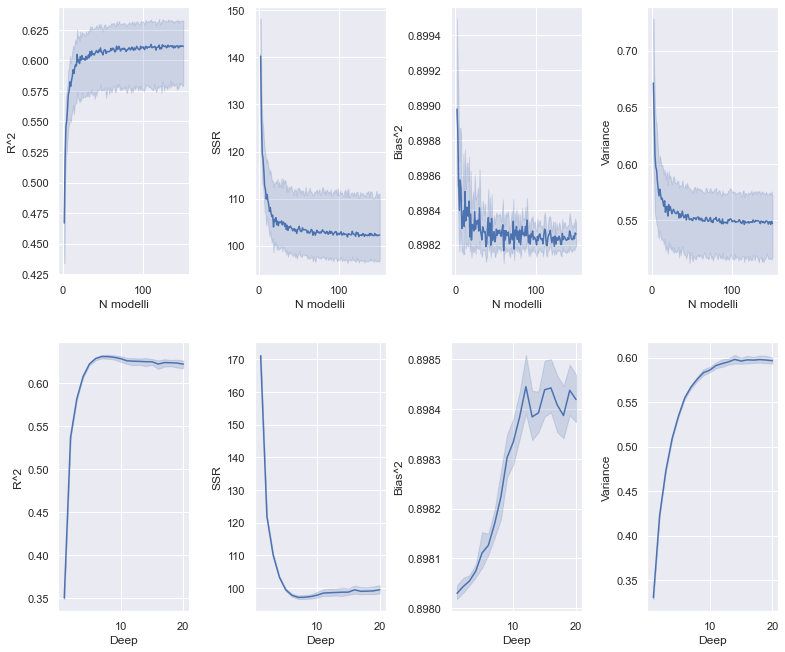

In [37]:
df_rf_mse = tuning_rf(150,20)

##### Miglior previsione

N modelli    36.000000
Deep         17.000000
R^2           0.652959
SSR          91.311503
Bias^2        0.898795
Variance      0.585044
Name: 696, dtype: float64


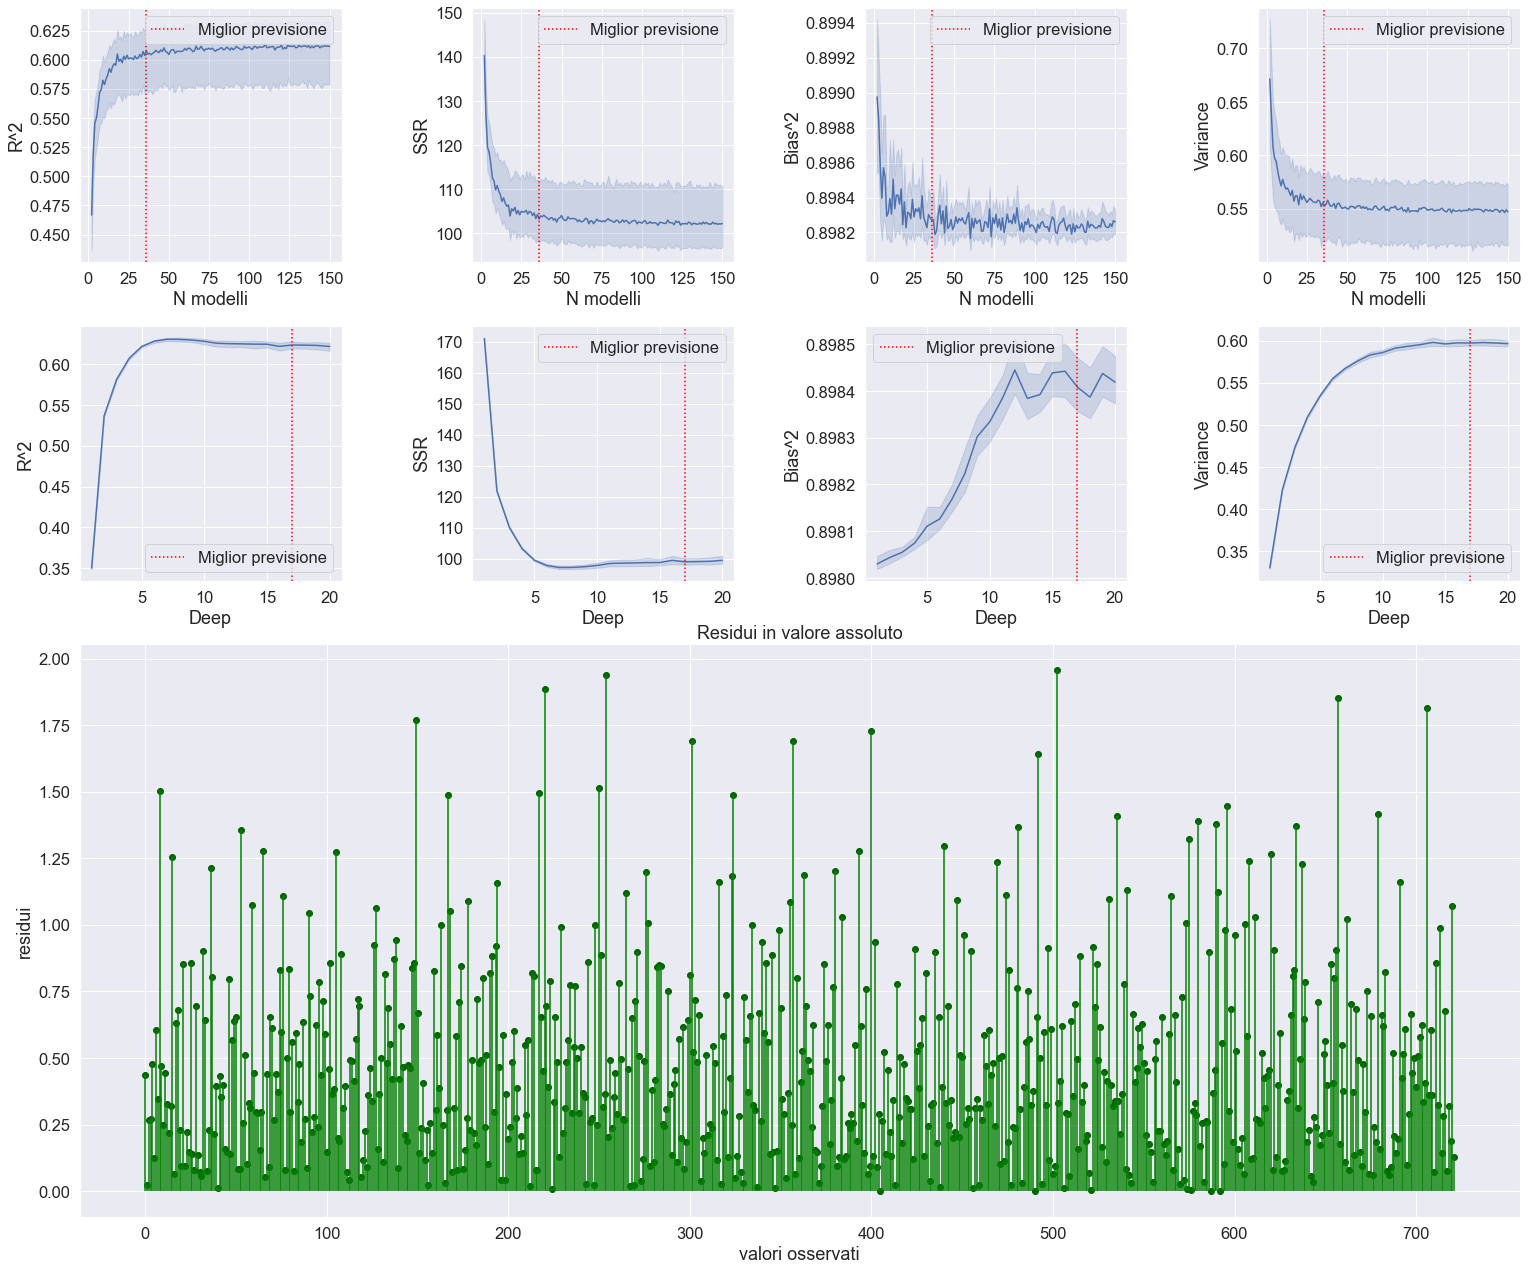

In [38]:
summary_rf_best(df_rf_mse)

<a id="2.6.2"/></a>
#### 2 Funzione per la misura della qualità dello split : mae

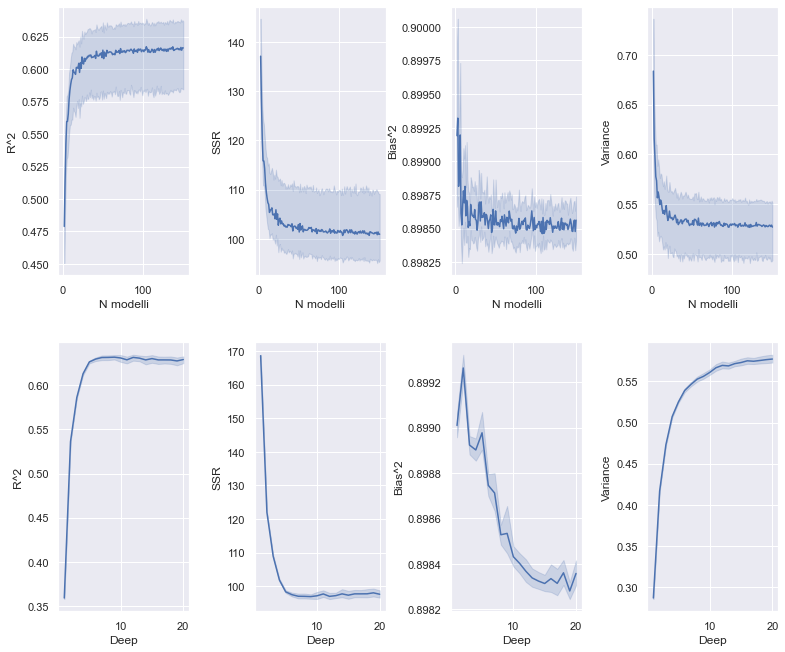

In [39]:
df_rf_mae = tuning_rf(150,20, criterion = "mae")

##### Miglior previsione

N modelli    66.000000
Deep         16.000000
R^2           0.659086
SSR          89.699260
Bias^2        0.898274
Variance      0.571555
Name: 1295, dtype: float64


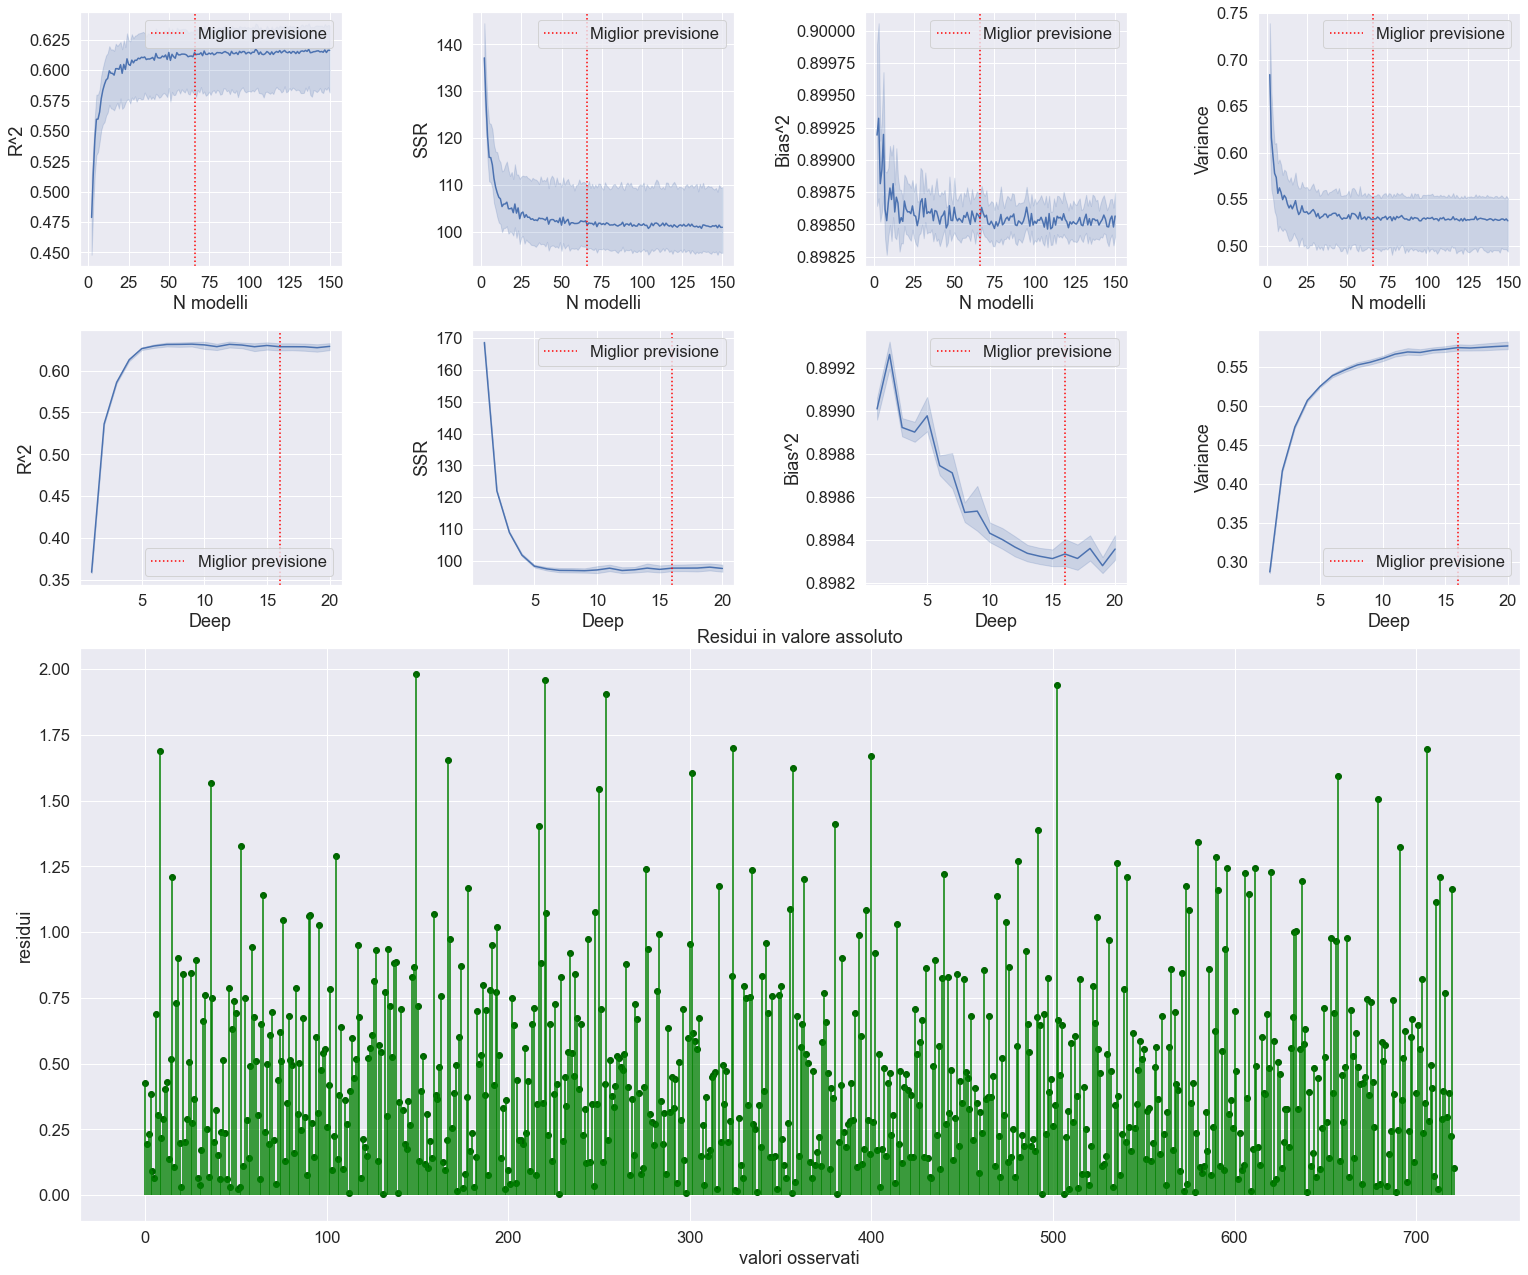

In [40]:
summary_rf_best(df_rf_mae, criterion = "mae")

<a id="3"/></a>
## 3 Confronto algoritmi di predizione

In [41]:
#mi torna il minimo dei massimi, mi serve per limitare l'asse delle x
def maxi_x(df_aux):
    mini = sys.maxsize
    for val in df_aux["Type"].unique():
        temp = max(df_aux["N"][df_aux["Type"] == val])
        if mini > temp:
            mini = temp
    return mini

#creo un df per poterlo plottare con seaborn
def create_df_for_plot(alg_1, alg_2):
    df_temp = []
    df_aux = pd.DataFrame() # questo mi serve per le linee
    for i in range(alg_1.columns.get_loc("R^2")): #creo una lista di dizionari per ogni parametro di tuning del 1° algoritmo
        df_temp.append(pd.DataFrame.from_dict({"N" : alg_1[alg_1.columns[i]], "Type" : alg_1.columns[i] + "_alg_1",
                                               "R^2" : alg_1["R^2"], "Bias^2" : alg_1["Bias^2"],
                                               "SSR" : alg_1["SSR"], "Variance" : alg_1["Variance"]}))
    for i in range(alg_2.columns.get_loc("R^2")): #creo una lista di dizionari per ogni parametro di tuning del 2° algoritmo
        df_temp.append(pd.DataFrame.from_dict({"N" : alg_2[alg_2.columns[i]], "Type" : alg_2.columns[i] + "_alg_2",
                                               "R^2" : alg_2["R^2"], "Bias^2" : alg_2["Bias^2"],
                                               "SSR" : alg_2["SSR"], "Variance" : alg_2["Variance"]}))
    for i, df in enumerate(df_temp): #unisco tutti i df sopra creati in uno unico
        df_aux = df_aux.append(df, ignore_index = True)
    return df_aux

# da un df di summary mi torna un dizionario con la combinazione di r^2 migliore
def convert_dictionary(df):
    d = {}
    for col in df:
        d[col] = df.iloc[df["R^2"].idxmax()][col]
    return d

# faccio un df con le info congiunte dei due algoritmi che sto analizzando
def create_comparison_info(alg_1, alg_2, inst_1, inst_2):
    #creo un df con nome delle righe l'unione dei nomi delle colonne dei due df dati come parametri
    df_info = pd.DataFrame(columns = ["alg_1", "alg_2", "alg_1-alg_2"], index = set(list(alg_1.columns) + list(alg_2.columns)
                                                                                    + ["MSE"]))
    first, second = convert_dictionary(alg_1), convert_dictionary(alg_2) #dizionari con i migliori tuning per entrambi gli algoritmi
    #aggiungo il MSE alla tabella
    first["MSE"] = -(cross_val_score(inst_1, df_p[df_p.columns.difference(["LAMBDArevenue"])], df_p["LAMBDArevenue"],
                                      cv=5, scoring='neg_mean_squared_error').mean())
    second["MSE"] = -(cross_val_score(inst_2, df_p[df_p.columns.difference(["LAMBDArevenue"])], df_p["LAMBDArevenue"],
                                      cv=5, scoring='neg_mean_squared_error').mean())
    for ind in df_info.index: #popolo il df_info
        if ind in first.keys():
            df_info["alg_1"].loc[ind] = first[ind]
        if ind in second.keys():
            df_info["alg_2"].loc[ind] = second[ind]
    for pos in df_info.index:
        if df_info["alg_1"].loc[pos] != None and df_info["alg_2"].loc[pos]:
            df_info["alg_1-alg_2"].loc[pos] = df_info["alg_1"].loc[pos] - df_info["alg_2"].loc[pos]
    return df_info
        
# compara due algoritmi mettendo a confronto i dati e i grafici prendendo il loro summary precedentemente calcolato
def comparison_alghoritm(alg_1, alg_2, inst_1, inst_2):
    sb.set(font_scale = 1.5) #modifico la scala
    print(create_comparison_info(alg_1, alg_2, inst_1, inst_2)) # stampo le info dei due algoritmi
    df_aux = create_df_for_plot(alg_1, alg_2) # df per plottare con seaborn
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(4,4) # creo la griglia di grafici
    axs = [fig.add_subplot(gs[0:2, 0:2]), fig.add_subplot(gs[0:2, 2:]),
          fig.add_subplot(gs[2:, 0:2]), fig.add_subplot(gs[2:, 2:])] #creo asse per grafici
    x_lim_max = maxi_x(df_aux)
    #do un limite all'asse x per avere una visualizzazione più "carina"
    for ax in axs:
        ax.set_xlim((0, x_lim_max))
    #plotto i grafici
    for i, y_value in enumerate(df_aux.columns[2:]):
        sb.lineplot(ax = axs[i], x = "N", y = y_value, hue = "Type", data = df_aux)
        #punto del tuning migliore per il 1° algoritmo
        axs[i].axhline(y = alg_1.loc[alg_1["R^2"].idxmax()][y_value], color = "magenta", linestyle = "-.",
                       linewidth = 2, label = "Scelta valore 1° algoritmo")
        #punto del tuning migliore per il 2° algoritmo
        axs[i].axhline(y = alg_2.loc[alg_2["R^2"].idxmax()][y_value], color = "cyan", linestyle = "-.",
                       linewidth = 2, label = "Scelta valore 2° algoritmo")
        axs[i].legend()
    # setta la posizione dei subplot
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.05, right=1.05, hspace=0.25,
                    wspace=0.5)
    sb.set(font_scale = 1) #modifico la scala

<a id="3.1"/></a>
### 1 K-Nearest-Neighbor(Manhattan distance) VS Albero di decisione (mae)

              alg_1     alg_2 alg_1-alg_2
Bias^2     0.898078  0.899183 -0.00110424
Leaf            NaN        14         NaN
R^2        0.527604  0.573192   -0.045588
Deep            NaN         4         NaN
Neighbors        14       NaN         NaN
MSE         0.47999  0.454115   0.0258747
SSR         124.294   112.299     11.9949
Variance   0.298331  0.572348   -0.274016


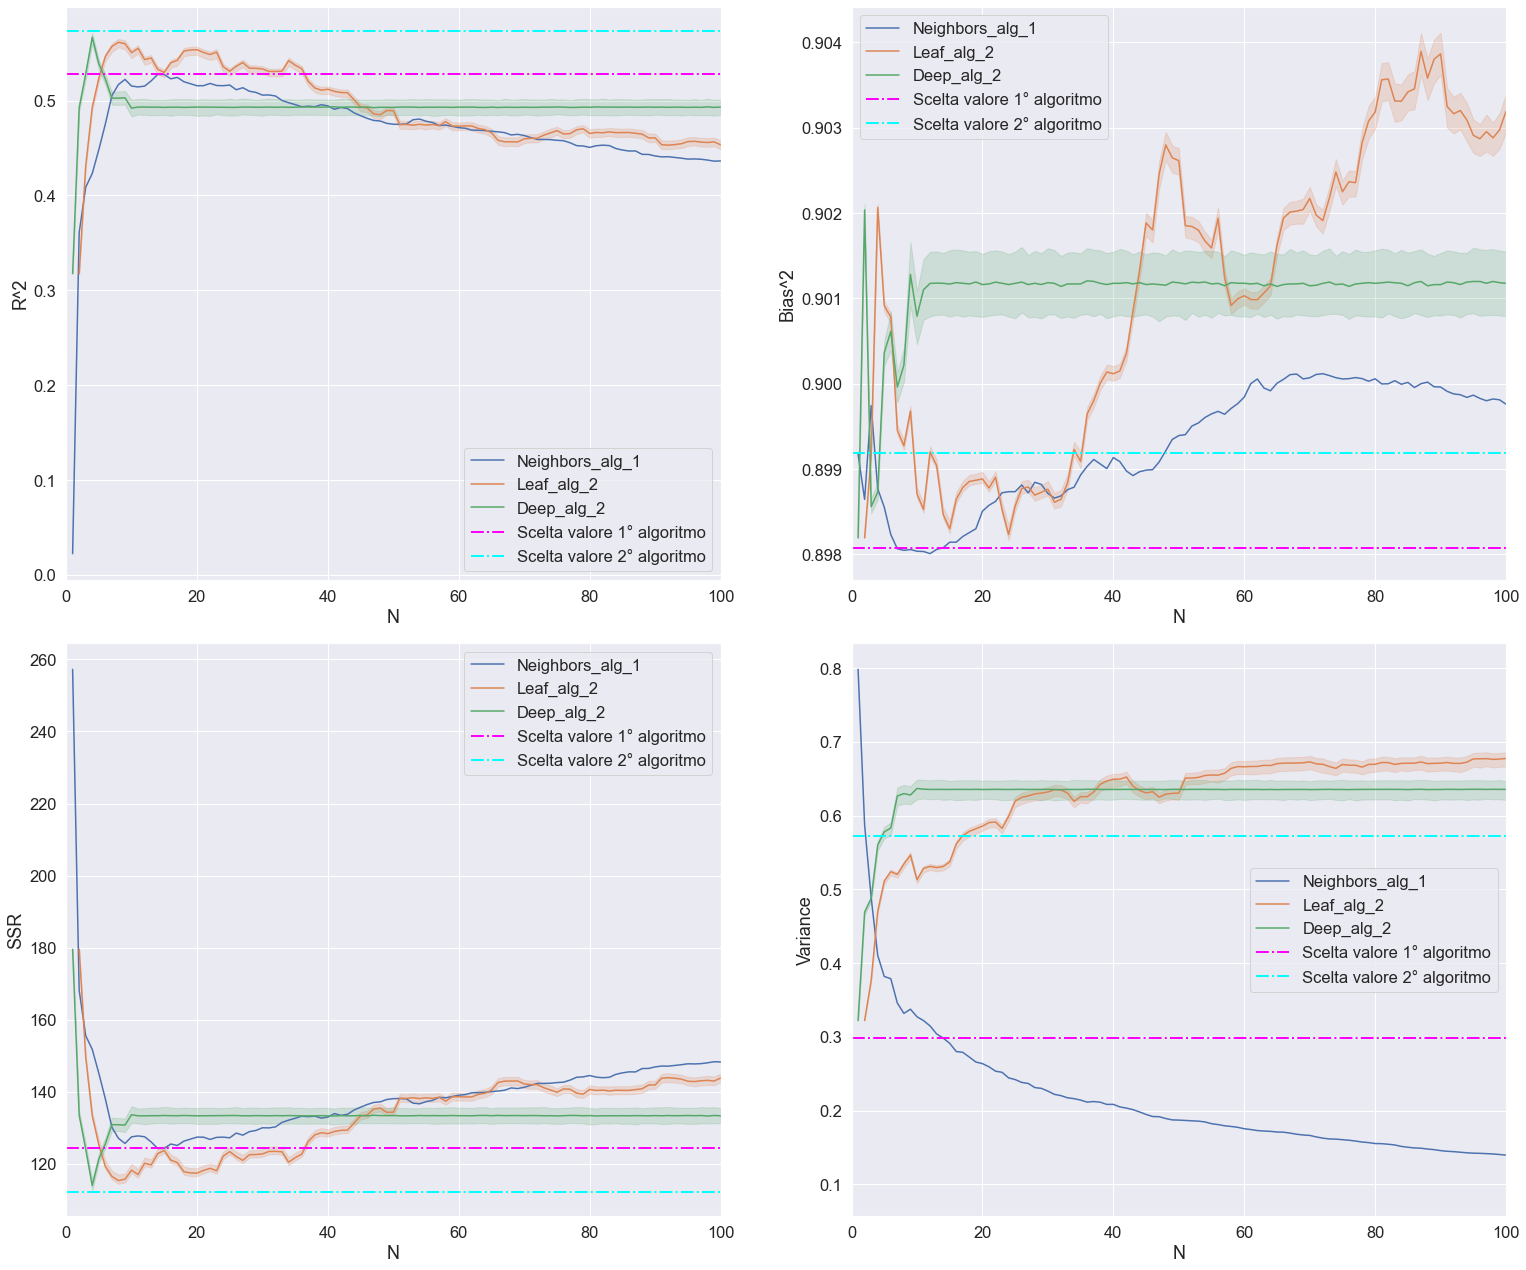

In [42]:
comparison_alghoritm(df_knn_md, df_dt_mae, KNeighborsRegressor(n_neighbors = 14, p = 1),
                     DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"))

Dai dati sovrastanti posso dedurre:

- L'accuratezza della previsione è decisamente maggiore nell'albero di decisione
- Knn ha una varianza nettamente più bassa in quanto più aumento le foglie in un albero più la sua varianza cresce
- Per quanto riguarda la distorsione i due algoritmi si equivalgono

In conclusione conviene utilizzare l'albero di decisione anche se presenta una varianza maggiore

<a id="3.2"/></a>
### 2 Random forest(mse) VS AdaBoost (linear)

In [ ]:
comparison_alghoritm(df_rf_mse, df_ada_l, RandomForestRegressor(n_estimators = 36, max_depth= 17,
                     AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"),
                                       n_estimators = 38))

Dai dati sovrastanti posso dedurre:

- L'accuratezza della previsione è decisamente maggiore nell'albero di decisione
- Knn ha una varianza nettamente più bassa in quanto più aumento le foglie in un albero più la sua varianza cresce
- Per quanto riguarda la distorsione i due algoritmi si equivalgono

In conclusione conviene utilizzare l'albero di decisione anche se presenta una varianza maggiore

<a id="4"/></a>
## 4 Miglior predizione
La miglior previsione è stata data dall'algoritmo di Adapting Boosting con una percentuale di adattamento del modello di $	\approx 65$%

In [43]:
# trova il miglior numero di feature che massimizzano R^2 e allo stesso tempo minimizzano MSE
def compromise_between_mse_r2(mse, r2):
    for i, val in enumerate(mse): #inverto i segni di mse cosi diventa un problema di massimizzazione e non di minimizzazione
         mse[i] = -val
    mse_pos = list(np.argsort(mse)) #posizioni di mse dalla più piccola alla più grande
    r2_pos = list(np.argsort(r2)) #posizioni di r2 dalla più piccola alla più grande
    maxi = 0 #mi tiene i pesi con il valore più grande(con pesi intendo la posizione che occupano nella lista ordinata, più in la sono più pesano)
    n_feature = -1 #mi da la quantità di feature che ha il compromesso migliore
    #  la i sono il numero di feature nel modello, quindi per ogni feature vado a vedere la somma dei pesi di r^2 e mse e scelgo quella migliore
    for i in range(len(mse_pos)):  #mse e r2 hanno la stessa lunghezza
        point_actual = mse_pos.index(i) + r2_pos.index(i) #somma dei pesi
        if point_actual > maxi:
            maxi = point_actual
            n_feature = i
    return n_feature + 1

    
    #mi da un insieme di grafici che mi descrivono le migliori feature e quali prendere per il modello
def best_feature():
    sb.set(font_scale = 1.5) #modifico la scala
    column = df_p.columns.difference(["LAMBDArevenue"]) #colonne dei predittori
    best_predictor_score_mse = [] #mi tiene i valori del mse per ogni predittore aggiunto
    best_predictor_score_r2 = [] #mi tiene i valori del r^2 per ogni predittore aggiunto
    ada_best = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"),
                                 n_estimators = int(df_ada_l.iloc[df_ada_l["R^2"].idxmax()]["N modelli"])) #algoritmo per avere i predittori
    ada_best.fit(x_train, y_train) #alleno l'algoritmo
    best_feature = np.argsort(ada_best.feature_importances_)[::-1] #indice delle feature dalla più importante alla meno importante
    for best_f in range(len(best_feature)): #popolo la lista con lo score
        ada_temp = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"),#algoritmo per lo score
                                 n_estimators = int(df_ada_l.iloc[df_ada_l["R^2"].idxmax()]["N modelli"]))
        mse = cross_val_score(ada_temp, df_p[column[best_feature[:(best_f + 1)]]], df_p["LAMBDArevenue"], #lista con gli mse
                              cv=5, scoring='neg_mean_squared_error') # best_f + 1 serve perchè il : mi considera fino all'elemento prima
        r2 = cross_val_score(ada_temp, df_p[column[best_feature[:(best_f + 1)]]], df_p["LAMBDArevenue"], #lista con gli r^2
                              cv=5, scoring='r2')
        best_predictor_score_mse.append(- mse.mean()) #media degli mse
        best_predictor_score_r2.append(r2.mean()) #media dei r^2
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(2,2) # creo la griglia di grafici
    ax0 = fig.add_subplot(gs[0, 0:]) #primo grafico
    plt.xticks(ticks = range(1, len(best_feature) + 1, 5)) #modifica la qunatità di valori nell'asse x per il 1° grafico
    ax1 = fig.add_subplot(gs[1, 0:]) #secondo grafico
    plt.xticks(ticks = range(1, len(best_feature) + 1, 5)) #modifica la qunatità di valori nell'asse x per il 2° grafico
    #primo grafico
    ax0.bar(range(len(ada_best.feature_importances_)), ada_best.feature_importances_)
    ax0.set_title("Feature più importanti")
    ax0.set(xlabel="Feature", ylabel = "Importanza")
    #secondo grafico
    ax1.plot(range(1, len(best_feature) + 1), best_predictor_score_mse, 'o-', color = "forestgreen", label = "MSE")
    ax1.plot(range(1, len(best_feature) + 1), best_predictor_score_r2, '*-', color = "red", label = "R^2")
    ax1.axvline(x = np.argsort(best_predictor_score_mse)[0] + 1, color = "limegreen", linestyle = "-.", #miglior MSE
                linewidth = 2, label = "Miglior MSE")
    ax1.axvline(x = np.argsort(best_predictor_score_r2)[-1] + 1, color = "orange", linestyle = "-.", #miglior R^2
                linewidth = 2, label = "Miglior R^2")
    val = compromise_between_mse_r2(best_predictor_score_mse, best_predictor_score_r2) #verifica la miglior coppia R^2 MSE
    n_best = val + 1 # se trovo un compromesso le migliori feature sono quelle
    ax1.axvline(x = val + 1, color = "blue", linestyle = "--",
                linewidth = 2, label = "Compromesso") #miglior coppia MSE e R^2
    ax1.set_title("Feature inserite nel modello")
    ax1.set(xlabel="Numero di feature utilizzate nel modello", ylabel = "MSE")
    ax1.legend()
    sb.set(font_scale = 1) #modifico la scala
    print(n_best)
    return best_feature[:n_best]

In [44]:
trasf = StandardScaler()
df_p = pd.DataFrame(columns = df.columns, data = trasf.fit_transform(df)) #creo un nuovo df con stessi nomi di colonna ma dati 
# standardizzati
x_train, x_test, y_train, y_test = train_test_split(df_p[df_p.columns.difference(["LAMBDArevenue"])],
                                                    df_p["LAMBDArevenue"], test_size = 0.2, random_state = 42)

<a id="4.1"/></a>
### 1 Features più rilevanti

38


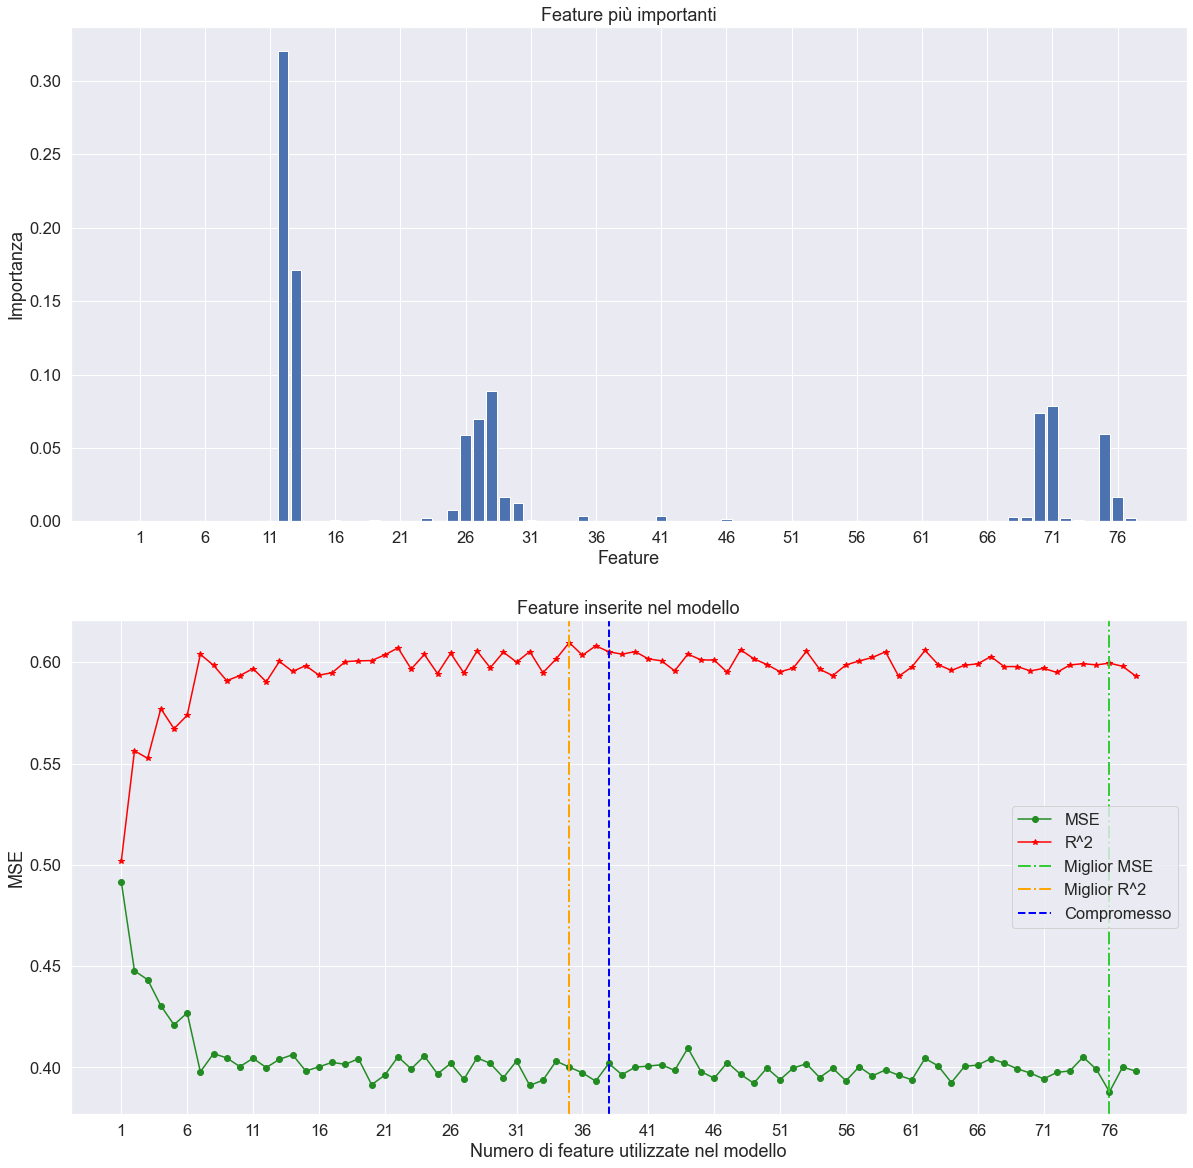

In [45]:
best_feat = best_feature()

Per avere una buona predizione devo ottenere un compromesso tra l'adattamento e l'errore quadratico medio del modello.
Dal grafico soprastante noto che questo tradeoff è dato dal tenere le prime 38 feature che danno più contributo nella predizione.

Sono le seguenti:

In [53]:
x_test.columns[best_feat]

Index(['LOGbudget', 'LOGpopularity', 'num_crew', 'release_year',
       'release_month', 'num_cast', 'there_is_belongs_to_collection',
       'num_Keywords', 'num_production_companies', 'there_is_homepage',
       'num_spoken_languages', 'genres_28', 'origin_language_en',
       'origin_language_hi', 'production_countries_US',
       'production_countries_IN', 'spoken_languages_en', 'genres_12',
       'there_is_tagline', 'origin_language_ko', 'spoken_languages_hi',
       'origin_language_cn', 'Production_Sound_Mixer_55227', 'Producer_3183',
       'Director_5714', 'production_countries_FR', 'origin_language_pl',
       'origin_language_zh', 'production_companies_11', 'cast_7624',
       'cast_71189', 'cast_7', 'production_companies_11749',
       'Production_Sound_Mixer_1550832', 'Production_Sound_Mixer_1545540',
       'production_companies_923', 'Producer_10968', 'Producer_10850'],
      dtype='object')

<a id="4.2"/></a>
### 2 Modello parsimonioso

In [54]:
 #mi da le info del modello parsimonioso
def thrifty_model(best_feat):
    ada_aux = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 14, max_depth= 4, criterion = "mae"),
                                 n_estimators = int(df_ada_l.iloc[df_ada_l["R^2"].idxmax()]["N modelli"]))
    ada_aux.fit(x_train[x_train.columns[best_feat]], y_train) #alleno l'algoritmo sulle feature scelte
    y_pred = ada_aux.predict((x_test[x_test.columns[best_feat]]))
    # stampa delle info
    print(f" R^2 : {ada_aux.score(x_test[x_test.columns[best_feat]], y_test)}\n",
          f"SSR : {sum((y_pred - y_test)**2)}\n", 
          f"Bias^2 : {np.mean((np.mean(y_pred) - y_test)**2)}\n",
          f"Variance : {np.var(y_pred)}\n")
    fig = plt.figure(constrained_layout = False, figsize=(20,20)) # creo la figura
    gs = fig.add_gridspec(1,2) # creo la griglia di grafici
    axbig = fig.add_subplot(gs[0, 0:])
    l_residual = abs(y_pred - y_test) #lista dei residui in valore assoluto
    for i, val in enumerate(l_residual): #super grafico
        axbig.scatter(i, val, color = "darkgreen") #punto i-esimo
        axbig.vlines(x = i, ymin = 0, ymax = val, color = "green") #linea i-esima
    axbig.set_title("Residui in valore assoluto") #titolo del super grafico
    axbig.set(xlabel="valori osservati", ylabel = "residui")
    return l_residual

 R^2 : 0.6543338814697668
 SSR : 166.95884422085734
 Bias^2 : 1.1032053096844374
 Variance : 0.6839802083814067



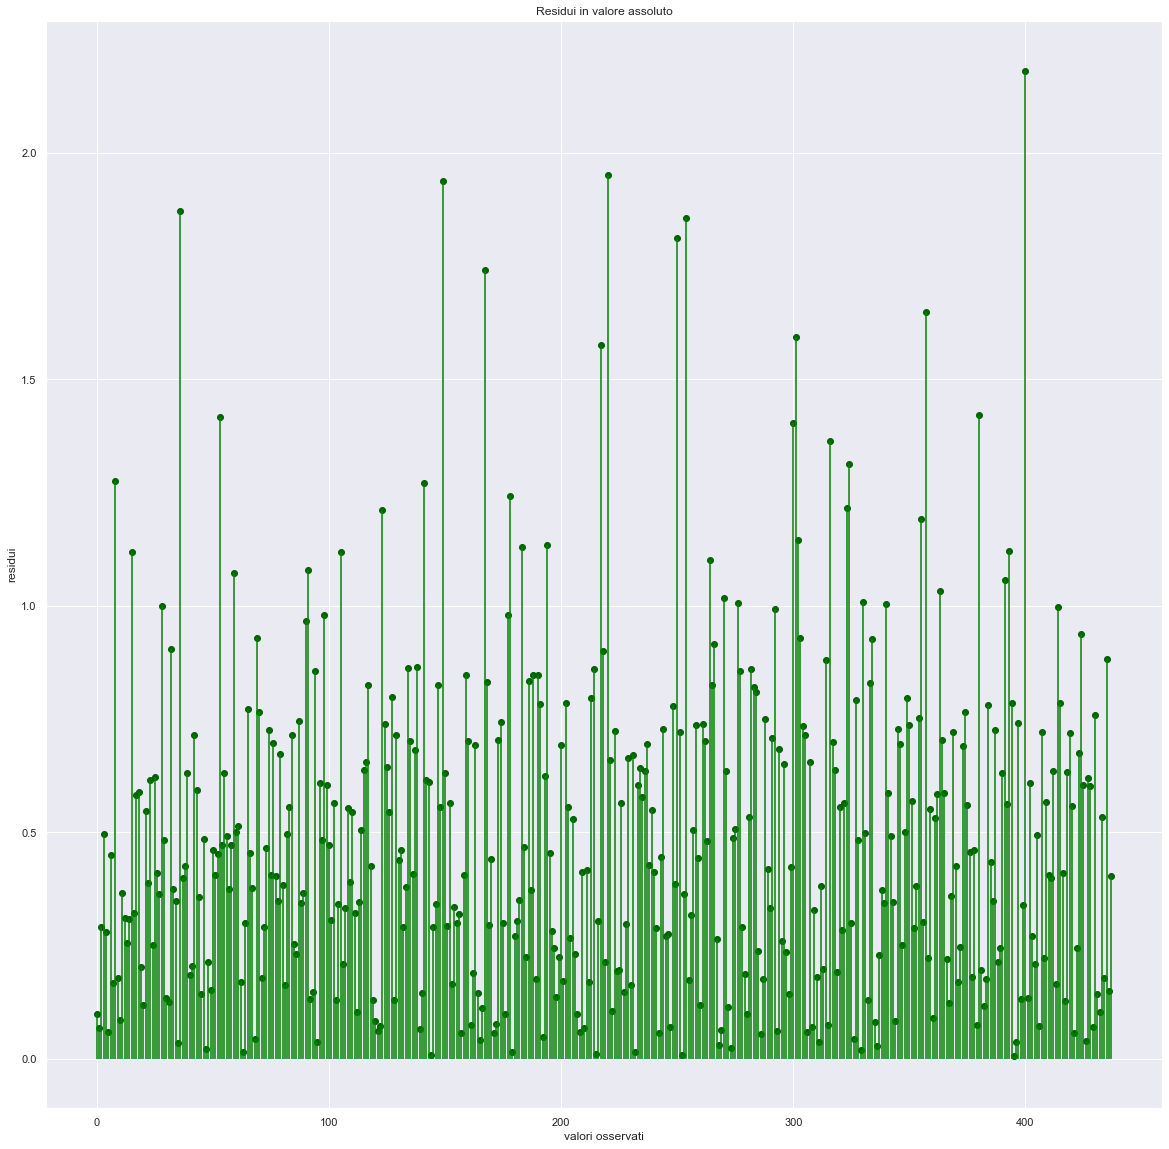

In [55]:
residuals = thrifty_model(best_feat)

<a id="5"/></a>
## 5 Conclusioni
In conclusione secondo la mia analisi l'algoritmo che da il miglior risultato raggiungendo un adattamento di $	\approx 65$%  è AdaBoosting con:
- 38 modelli
- La funzione da utilizzare per l'aggiornamento dei pesi dopo ogni iterazione è quella lineare
- Come stimatore viene utilizzato l'albero di decisione con:
    - numero massimo di foglie impostato a 14
    - numero massimo di profondità impostato a 4
    - come funzione per la qualità dello split la media dell'errore assoluto

Per quanto riguarda la scelta delle feature da utilizzare si rimanda al punto [4.1](#4.1)